>[1 Data Overview](#dataoverview)

>[2 Exploratory Data Analysis](#eda)

>[3 Preprocessing](#preprocessing)

>[4 Model and Validation](#modelvalidation)

>>[Supervised Learning](#supervised)

>>[Unsupervised Learning](#unsupervised)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px
import numpy as np
from scipy.stats import zscore
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# <a id=dataoverview> 1 Data Overview

- Data Reading 

In [2]:
df = pd.read_csv("../dataset/heart_disease.csv")
df.shape

(2463, 18)

> Dataset terdiri dari 319795 baris dan 18 kolom.

- Head

In [3]:
df.head().style.background_gradient(cmap='Pastel2')

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,24.210000,No,No,No,2.000000,1.000000,No,Male,25-29,Other,No,Yes,Good,7.000000,No,No,No
1,No,31.570000,Yes,No,No,0.000000,1.000000,No,Female,65-69,White,No,Yes,Very good,6.000000,No,No,No
2,Yes,21.090000,No,No,No,0.000000,0.000000,No,Female,75-79,Hispanic,No,Yes,Excellent,6.000000,No,No,No
3,Yes,21.460000,Yes,No,No,30.000000,0.000000,Yes,Female,65-69,White,No,No,Fair,8.000000,Yes,No,Yes
4,Yes,25.390000,Yes,No,No,0.000000,5.000000,Yes,Female,65-69,White,No,Yes,Good,8.000000,No,No,No


> Kolom dengan warna adalah kolom numerik, sementara kolom tidak berwarna menunjukkan kolom kategorikal.

- Dataset Info

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HeartDisease      2463 non-null   object 
 1   BMI               2463 non-null   float64
 2   Smoking           2463 non-null   object 
 3   AlcoholDrinking   2463 non-null   object 
 4   Stroke            2463 non-null   object 
 5   PhysicalHealth    2463 non-null   float64
 6   MentalHealth      2463 non-null   float64
 7   DiffWalking       2463 non-null   object 
 8   Sex               2463 non-null   object 
 9   AgeCategory       2463 non-null   object 
 10  Race              2463 non-null   object 
 11  Diabetic          2463 non-null   object 
 12  PhysicalActivity  2463 non-null   object 
 13  GenHealth         2463 non-null   object 
 14  SleepTime         2463 non-null   float64
 15  Asthma            2463 non-null   object 
 16  KidneyDisease     2463 non-null   object 


- Fitur Numerikal dan Kategorikal

In [5]:
# fitur numerikal
num_cols = df.select_dtypes(exclude='object').columns
print('Fitur numerikal:\n', num_cols.to_list())

# fitur kategorikal
obj_cols = df.select_dtypes(include='object').columns[1:]
print('\nFitur kategorikal:\n', obj_cols.to_list())

Fitur numerikal:
 ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']

Fitur kategorikal:
 ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']


> Tampak bahwa sebagian besar fitur adalah ketegorikal.

# <a id=eda> 2 Exploratory Data Analysis

### Numerical Description 

In [6]:
df.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,2463.000000,2463.000000,2463.000000,2463.000000
mean,28.543752,3.946407,4.079172,7.127081
std,6.682202,8.594553,8.273640,1.540045
min,15.660000,0.000000,0.000000,1.000000
25%,24.030000,0.000000,0.000000,6.000000
50%,27.440000,0.000000,0.000000,7.000000
75%,31.640000,2.000000,3.000000,8.000000
max,92.530000,30.000000,30.000000,20.000000


> Dari deskripsi fitur numerikal tersebut tampak bahwa:
> - *BMI* tidak seimbang (_skewed_).
> - *PhysicalHealth* dan *MentalHealth* sangat tidak seimbang (_skewed_) karena jumlah angka nol.
> - *SleepTime* terdistribusi normal.

### Categorical Description 

In [7]:
df.describe(include="object").T

,count,unique,top,freq
HeartDisease,2463,2,No,2000
Smoking,2463,2,No,1379
AlcoholDrinking,2463,2,No,2301
Stroke,2463,2,No,2342
DiffWalking,2463,2,No,2062
Sex,2463,2,Female,1273
AgeCategory,2463,13,65-69,300
Race,2463,6,White,1911
Diabetic,2463,4,No,2024
PhysicalActivity,2463,2,Yes,1876


> Dari deskripsi fitur kategorikal tersebut tampak bahwa:
> - *SleepTime* terdistribusi normal.
> - Ada ketidakseimbangan kelas yang parah (penyakit jantung vs sehat)
> - *Age* bersifat kategoris (dibagi menjadi beberapa kelompok).
> - Terdapat atribut dengan _values_ yang tidak seimbang (_imbalanced_), yaitu:
>     - *Alcohol*
>     - *Stroke* 
>     - *DiffWalking* 
>     - *Race*
>     - *Diabetic* 
>     - *PhysicalActivity*
>     - *Asthma* 
>     - *KidneyDisease* 
>     - *SkinCancer* 

### Rasio penyakit jantung

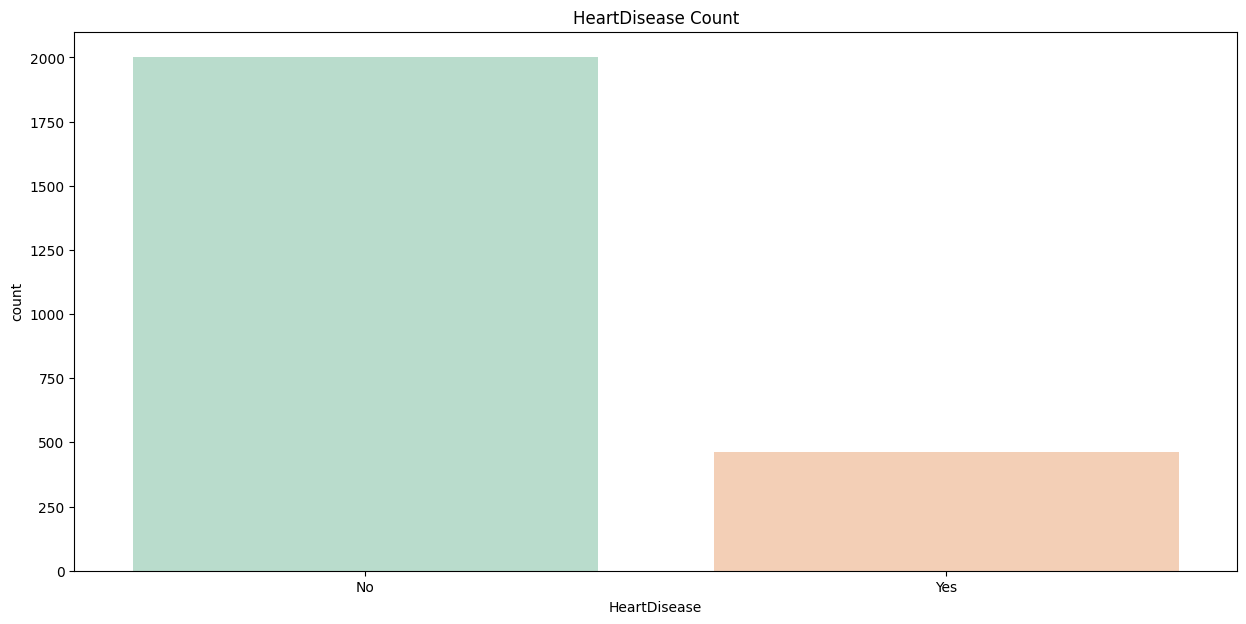

['No (81.2%)', 'Yes (18.8%)']


In [8]:
plt.figure(figsize=(15,7))
plt.title('HeartDisease Count')
sns.countplot(data=df, x='HeartDisease', hue='HeartDisease', palette='Pastel2', order=df['HeartDisease'].value_counts().index, legend=False)
plt.show()
heart_dis = (df.groupby('HeartDisease').size()*100 / len(df)).to_dict()
print([f"{k} ({round(v / sum(heart_dis.values()) * 100, 2)}%)" 
            for k, v in heart_dis.items()])

> Sekitar 8.56% orang menderita penyakit jantung di Amerika Serikat.

### Distribusi Fitur Numerikal

Text(0.5, 0.98, 'Distribution of Numerical Values')

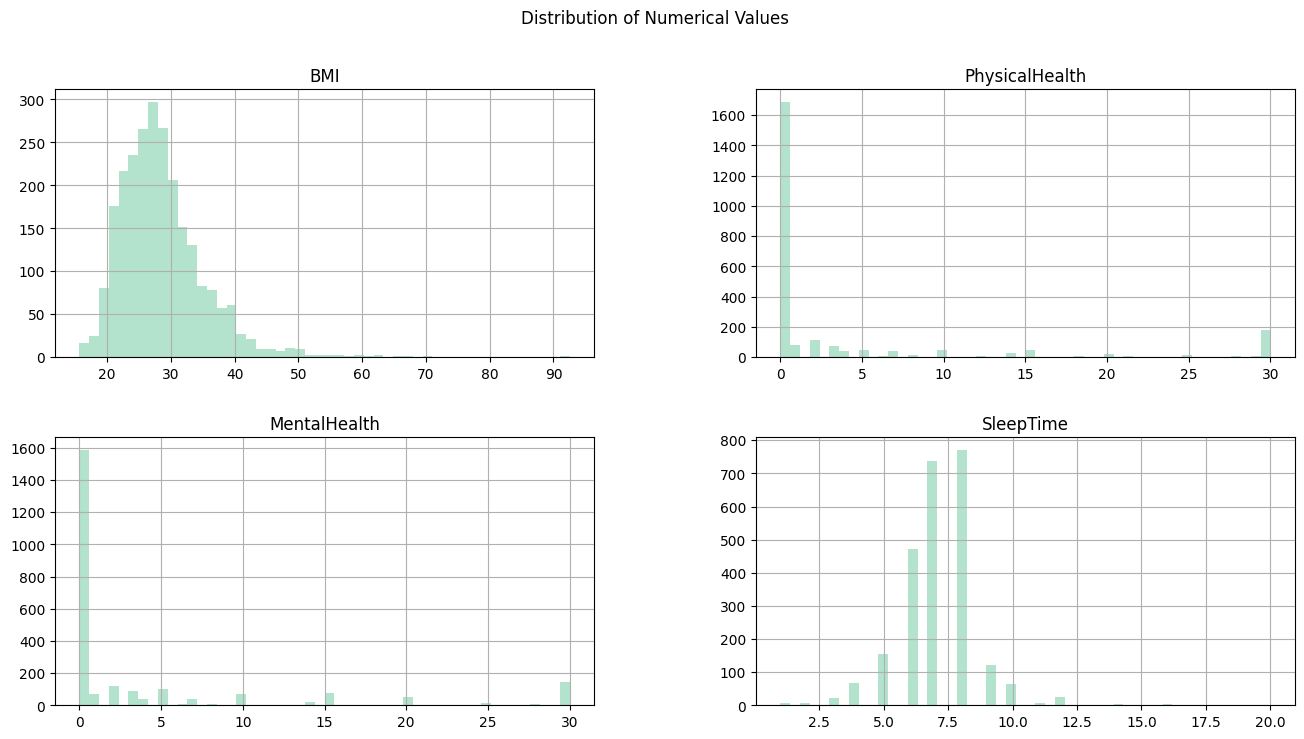

In [9]:
df.hist(figsize=(16, 8), bins=50, color='#B3E2CD')
plt.suptitle("Distribution of Numerical Values")

### Distribusi Fitur Kategorikal

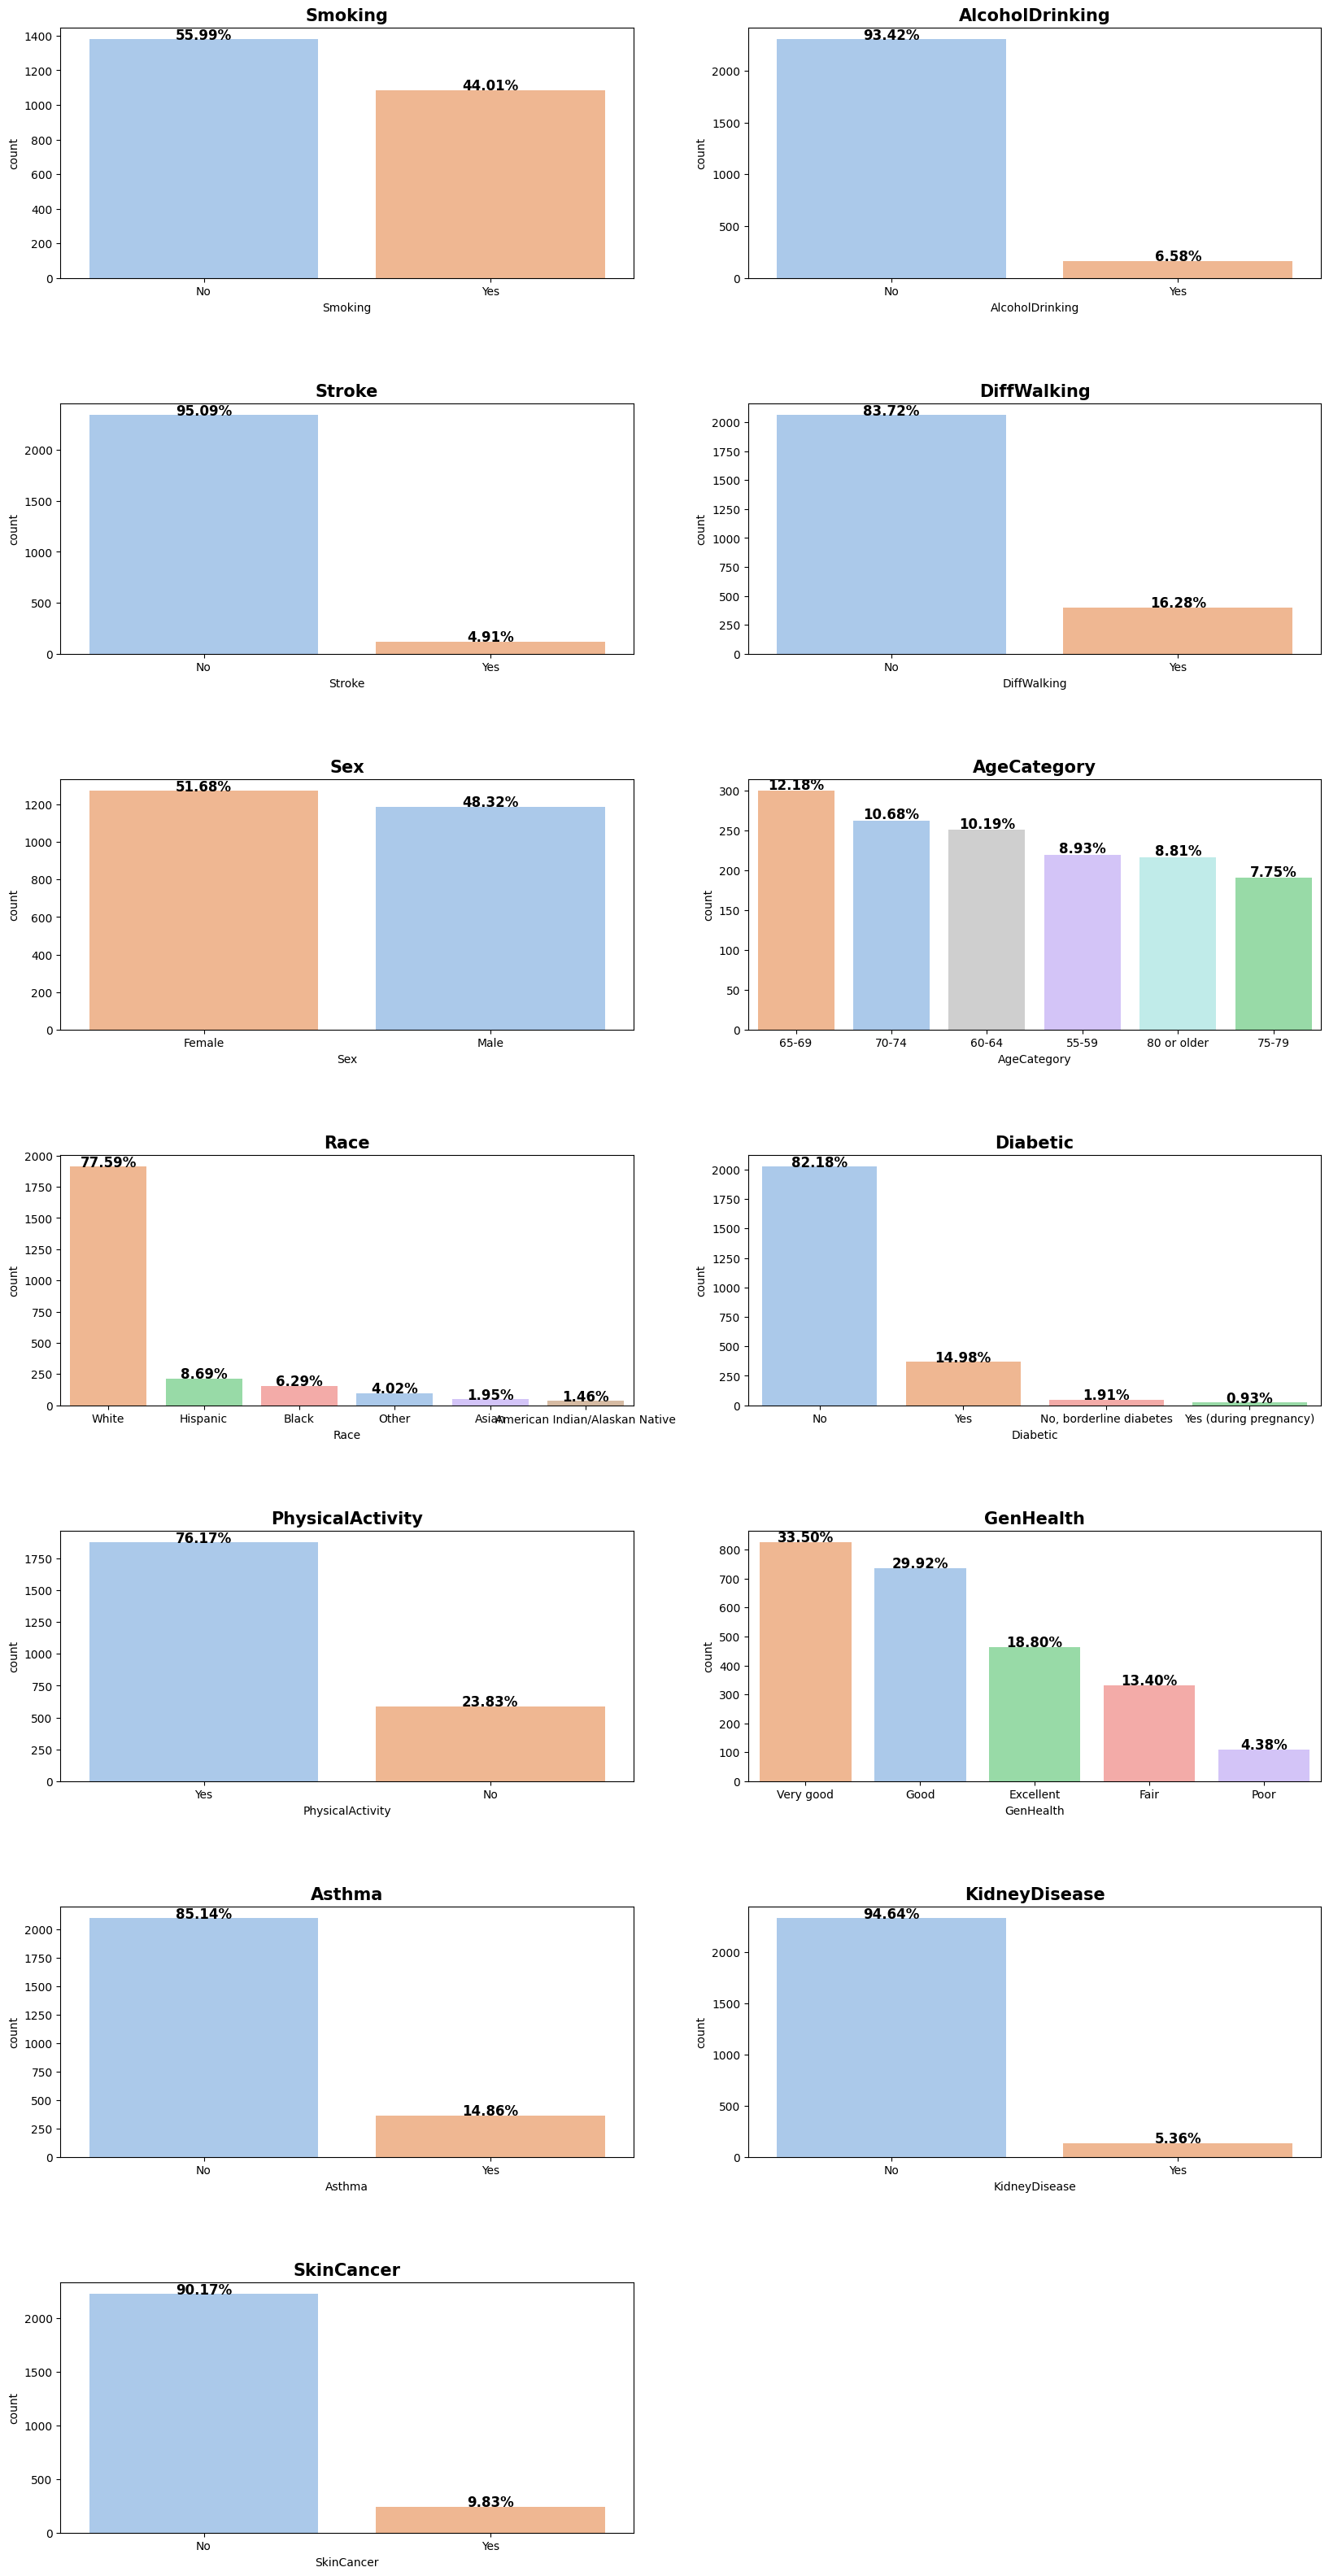

In [10]:
plt.figure(figsize=(20, 40))

for i in range(len(obj_cols)):
    plt.subplot(7, 2, i + 1)
    unique_count = df[obj_cols[i]].nunique()
    palette = sns.color_palette('pastel', unique_count)
    ax = sns.countplot( data=df, x=obj_cols[i], hue=obj_cols[i], palette=palette, 
                       order=df[obj_cols[i]].value_counts().index[:6], legend=False)

    plt.title(f'{obj_cols[i]}', fontsize=15, fontweight='bold', color='black')
    plt.subplots_adjust(hspace=0.5)

    for p in ax.patches:
        height = p.get_height()
        width = p.get_width()
        percent = height / len(df)
        ax.text( x=p.get_x() + width / 2, y=height + 2, s=format(percent, ".2%"),
                 fontsize=12, ha='center', weight='bold')

plt.show()

> Dari hasil plot tersebut dapat diketahui bahwa:
> - Sebagian besar orang dalam dataset adalah berkulit putih dan tidak memiliki diabetes.
> - Sebagian besar dari mereka telah melakukan aktivitas fisik selama 30 hari terakhir di luar pekerjaan rutin mereka.
> - Sebagian besar orang mengatakan bahwa mereka umumnya memiliki kesehatan yang baik-sangat baik, sedangkan hanya sedikit orang yang mengatakan bahwa mereka umumnya memiliki kesehatan yang buruk.
> - Hanya sedikit dari mereka yang memiliki asma, penyakit ginjal, dan kanker kulit.

Fungsi Pembantu

In [11]:
def show_relation(col, according_to, type_='dis'):
    plt.figure(figsize=(15, 7))
    unique_values = df[col].nunique()
    if according_to is not None:
        unique_hue_values = df[according_to].nunique()
    else:
        unique_hue_values = 1
    
    colors_col = sns.color_palette('Pastel2', unique_values)
    colors_hue = sns.color_palette('Pastel2', unique_hue_values)
    
    if type_ == 'dis':
        sns.displot(data=df, x=col, hue=according_to, kind='kde', palette=colors_hue)
    elif type_ == 'count':
        if according_to is not None:
            perc = df.groupby(col)[according_to].value_counts(normalize=True).reset_index(name='Percentage')
            sns.barplot(data=perc, x=col, y='Percentage', hue=according_to, 
                        palette=colors_hue, order=df[col].value_counts().index)
        else:
            sns.countplot(data=df, x=col, hue=according_to, palette=colors_col, order=df[col].value_counts().index)
    if according_to is None:
        plt.title(f'{col}')
    else:
        plt.title(f'{col} dan {according_to}')
    
    plt.show()


### BMI dan HeartDisease

<Figure size 1500x700 with 0 Axes>

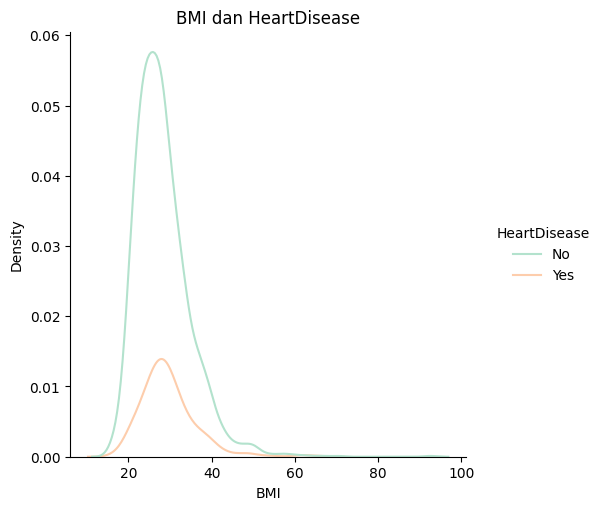

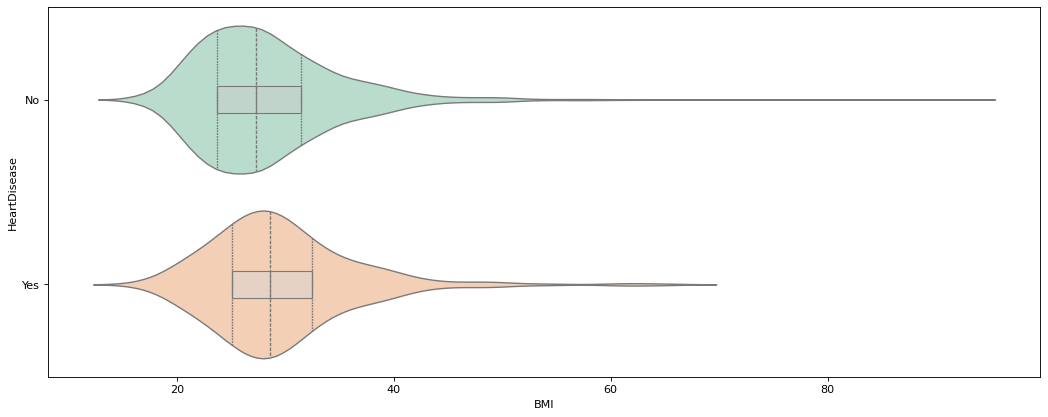

In [12]:
show_relation(num_cols[0], 'HeartDisease')

plt.figure(figsize=(16, 6), dpi=80)
unique_count = df['HeartDisease'].nunique()
palette = sns.color_palette('Pastel2', unique_count)

sns.boxplot( data=df, x='BMI', y='HeartDisease', hue='HeartDisease', saturation=0.4, width=0.15, 
            boxprops={'zorder': 2}, showfliers=False, whis=0, palette=palette, legend=False)
sns.violinplot( data=df, x='BMI', y='HeartDisease', hue='HeartDisease', inner='quartile', palette=palette, legend=False)

plt.show()

> Kedua distribusi menunjukkan pola distribusi normal dan berada dalam rentang yang sama, yaitu dari 12 hingga 94. Distribusi BMI pada individu yang menderita penyakit jantung sedikit bergeser ke nilai yang lebih tinggi dibandingkan dengan distribusi BMI pada mereka yang tidak mengalami penyakit jantung. 

> Dengan begitu, maka **BMI tidak memiliki pengaruh signifikan terhadap penyakit jantung**. Artinya, meskipun ada perbedaan kecil dalam distribusi BMI antara kedua kelompok tersebut, BMI sendiri tidak secara langsung berhubungan atau tidak cukup mempengaruhi kemungkinan terjadinya penyakit jantung dalam dataset ini.

### MentalHealth dan HeartDisease

<Figure size 1500x700 with 0 Axes>

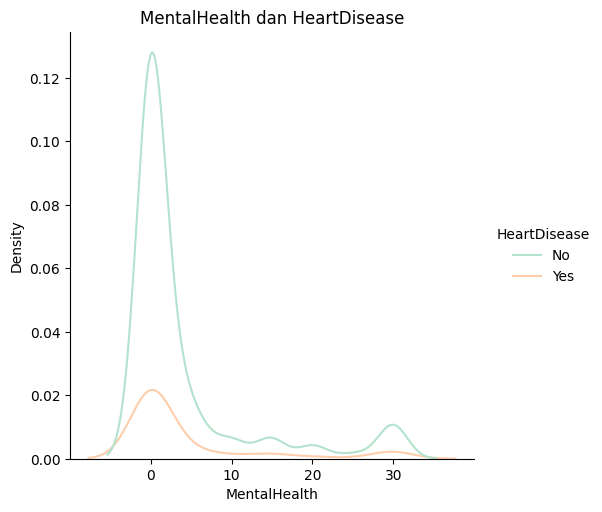

In [13]:
show_relation(num_cols[2], 'HeartDisease')

### AgeCategory dan HeartDisease

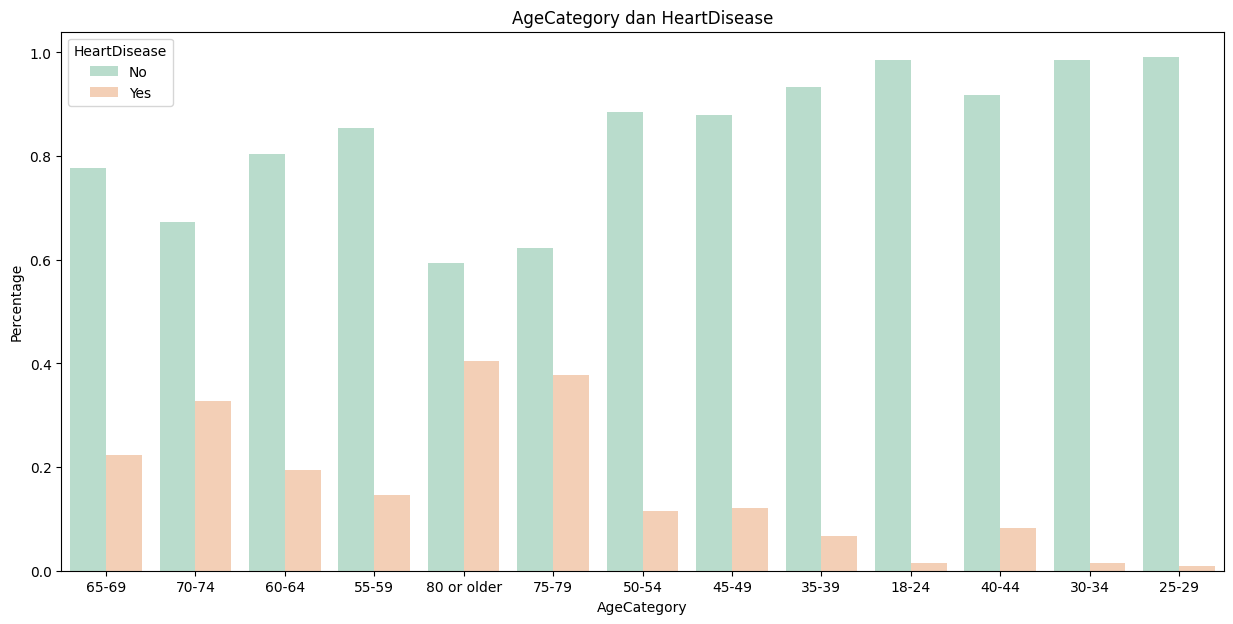

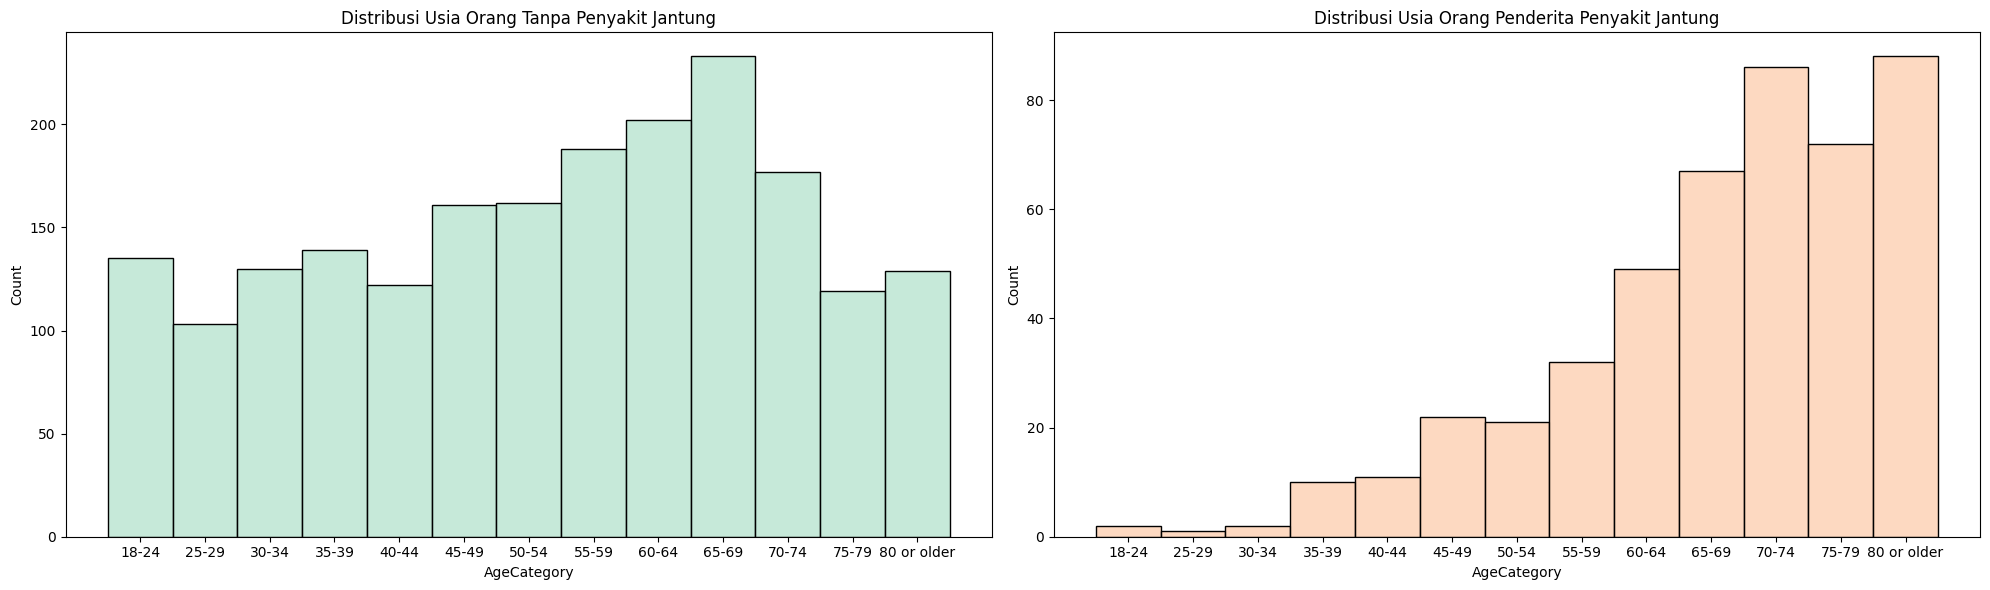

In [14]:
show_relation(obj_cols[5], 'HeartDisease', type_='count')
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 6))
pastel_palette = sns.color_palette('Pastel2')
sns.histplot(data=df.loc[df.HeartDisease == 'No'].sort_values("AgeCategory"), x='AgeCategory',
                  color=pastel_palette[0], ax=ax1)
ax1.set_title("Distribusi Usia Orang Tanpa Penyakit Jantung")

sns.histplot(data=df.loc[df.HeartDisease == 'Yes'].sort_values("AgeCategory"), x='AgeCategory',
                  color=pastel_palette[1], ax=ax2)
ax2.set_title("Distribusi Usia Orang Penderita Penyakit Jantung")

fig.tight_layout()

> Dapat kita lihat bahwa usia memainkan peran besar dalam penyakit jantung. Hal ini karena jumlah pasien penyakit jantung meningkat seiring bertambahnya usia. Orang-orang yang paling rentan terhadap penyakit jantung adalah mereka yang berusia di atas 70 tahun.

### Sex dan HeartDisease

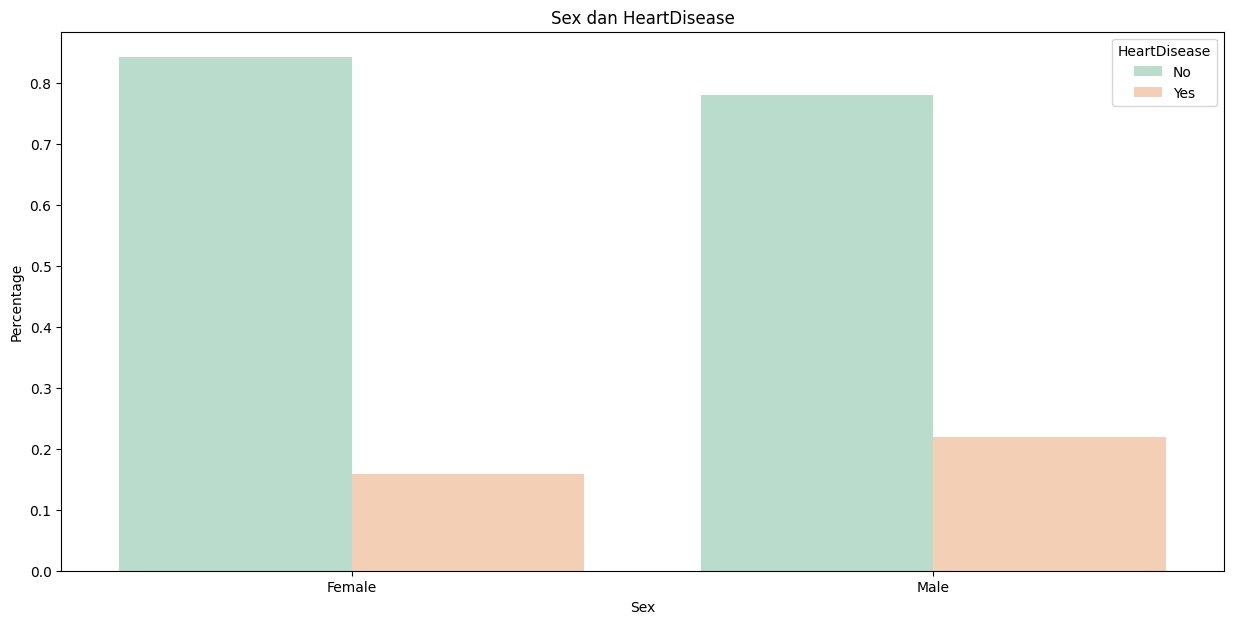

In [15]:
show_relation(obj_cols[4], 'HeartDisease', type_='count')

> Dari dataset tersebut tampak bahwa laki-laki lebih rentan terhadap penyakit jantung.

### Race dan HeartDisease

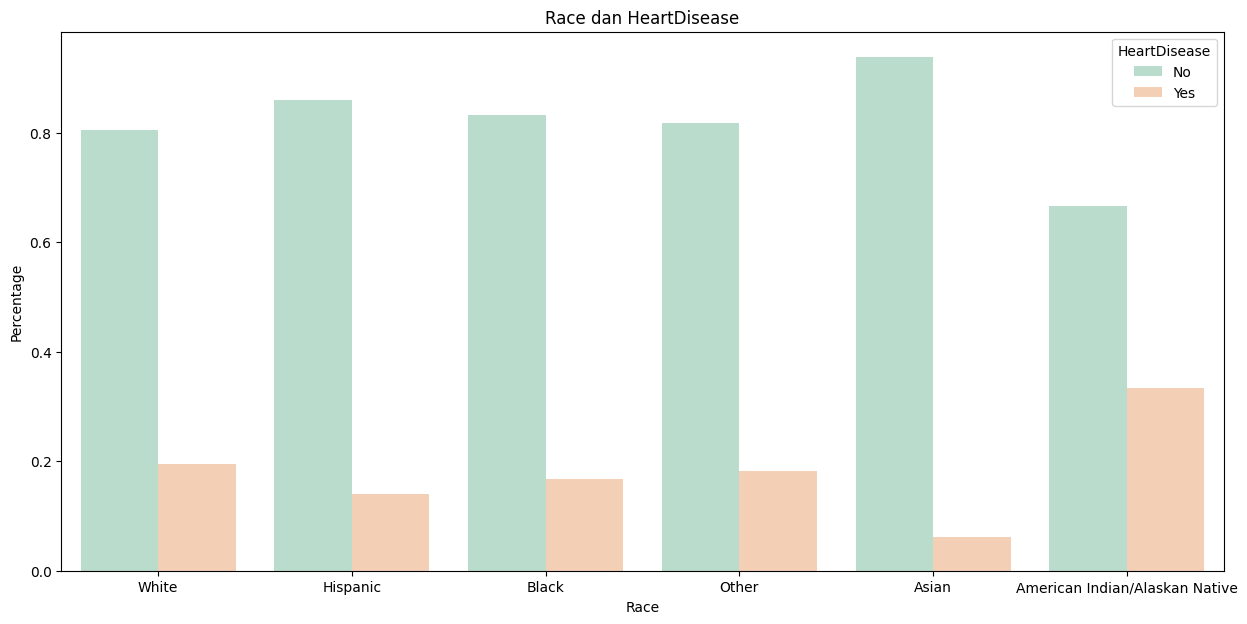

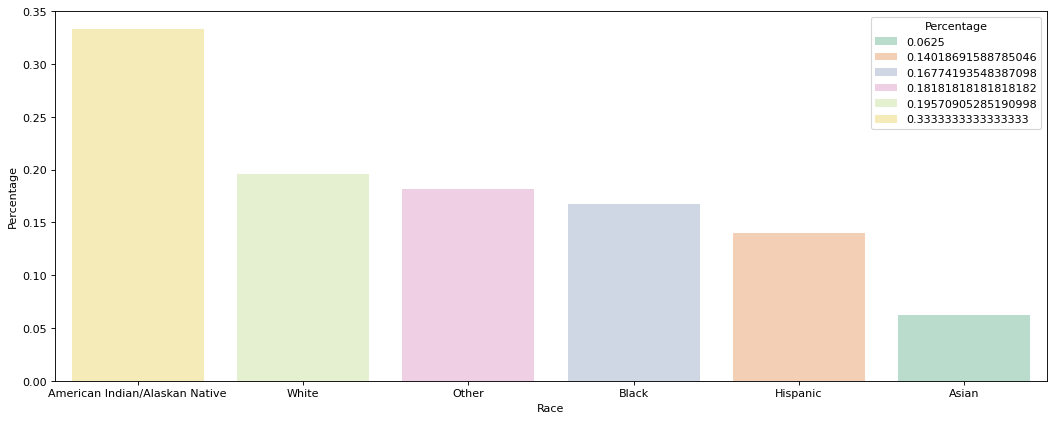

In [16]:
show_relation(obj_cols[6], 'HeartDisease', type_='count')

plt.figure(figsize=(16, 6), dpi=80)
x = df.groupby('Race').HeartDisease.value_counts(normalize=True).reset_index(name='Percentage')
x = x.loc[x.HeartDisease == 'Yes'].sort_values('Percentage', ascending=False)

unique_count = df['Race'].nunique()
pastel_palette = sns.color_palette('Pastel2', unique_count)
sns.barplot(data=x, x='Race', y='Percentage', hue='Percentage', palette=pastel_palette)
plt.show()

> Sebagian besar orang yang menderita penyakit jantung adalah orang American Indian/Alaskan Native (>10%), ementara persentase penyakit jantung terendah (~3%) ada di antara orang-orang Asia. Namun, ras tidak bisa menjadi pertimbangan karena kita tahu bahwa ras tidak memiliki korelasi atau pengaruh terhadap penyakit jantung.

### GenHealth dan HeartDisease

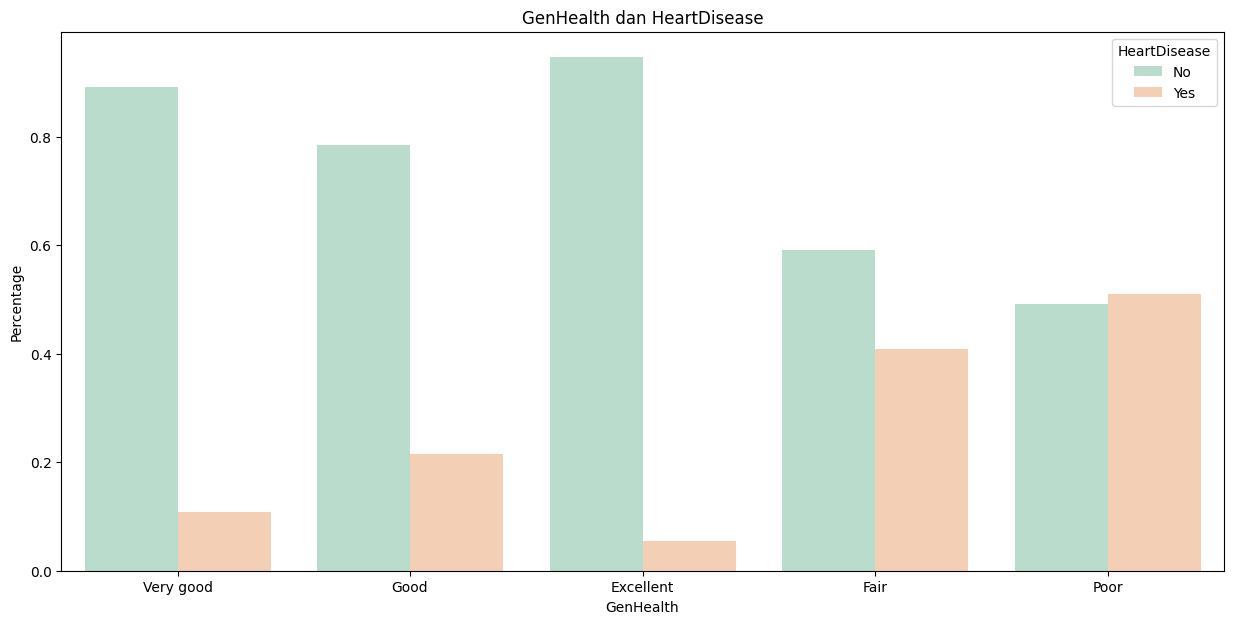

In [17]:
show_relation(obj_cols[9], 'HeartDisease', type_='count')

x = df.groupby('HeartDisease').GenHealth.value_counts(normalize=True).reset_index(name='Percentage')
x = x.sort_values(by='GenHealth', key=lambda x: x.map({'Excellent': 0, 'Very good': 1, 'Good': 2, 'Fair': 3, 'Poor': 4} ))
x.Percentage = round(x.Percentage * 100, 1) 

fig = px.bar(data_frame=x, x='Percentage', y='HeartDisease', color='GenHealth',
       text=x.Percentage.map(lambda x: str(x) + '%'), 
       color_discrete_sequence=['#0f1e41', '#E80000', '#ff4d4d', '#ff8080', '#ffb3b3', '#ffe6e6'])
fig.update_layout(title="Kesehatan", title_x=0.5)

fig.show()

### PhysicalHealth dan HeartDisease

<Figure size 1500x700 with 0 Axes>

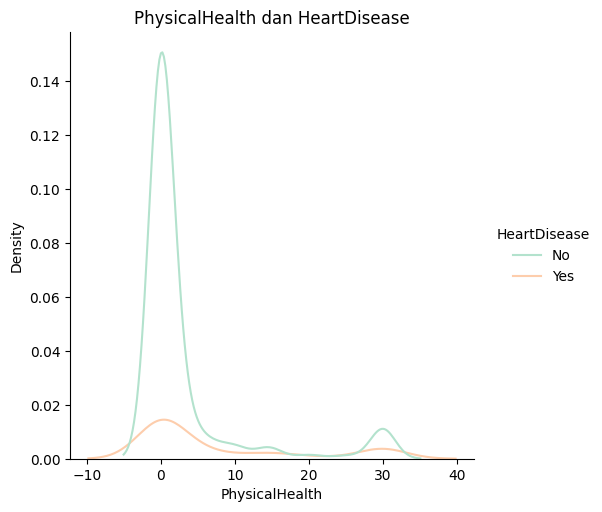

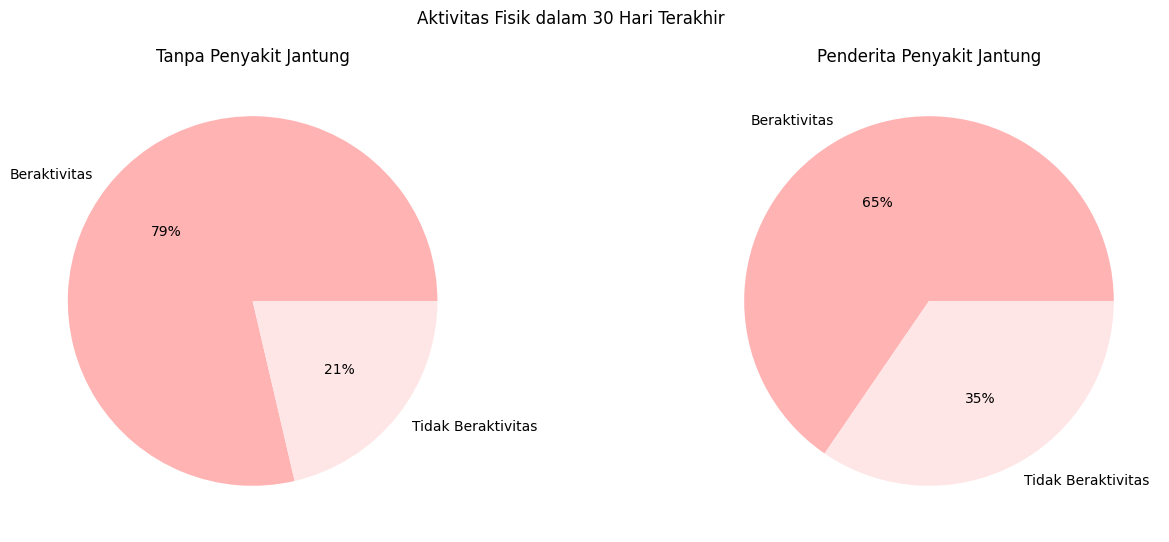

In [18]:
show_relation(num_cols[1], 'HeartDisease')

x = df.groupby('HeartDisease').PhysicalActivity.value_counts().reset_index(name='Count').Count
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
fig.suptitle("Aktivitas Fisik dalam 30 Hari Terakhir")

ax1.pie([x[0], x[1]], labels = ['Beraktivitas', 'Tidak Beraktivitas'], colors=['#ffb3b3', '#ffe6e6'], autopct='%.0f%%')
ax1.set_title("Tanpa Penyakit Jantung")
ax2.pie([x[2], x[3]], labels = ['Beraktivitas', 'Tidak Beraktivitas'], colors=['#ffb3b3', '#ffe6e6'], autopct='%.0f%%')
ax2.set_title("Penderita Penyakit Jantung")

plt.show()

### SleepTime dan HeartDisease

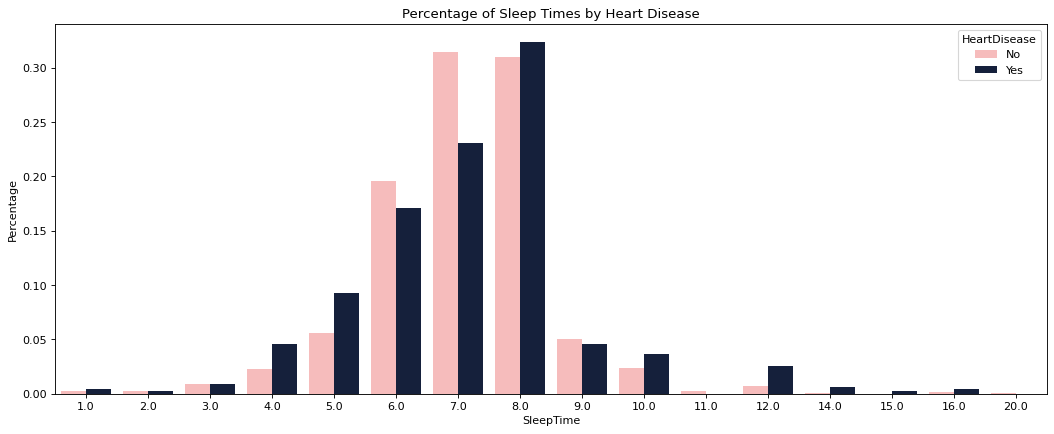

In [19]:
relative = df.groupby('HeartDisease').SleepTime.value_counts(normalize=True).reset_index(name='Percentage')
plt.figure(figsize=(16, 6), dpi=80)
ax = sns.barplot(data=relative, x='SleepTime', y='Percentage', hue='HeartDisease', palette=['#ffb3b3', '#0f1e41'])
ax.set_title("Percentage of Sleep Times by Heart Disease")
plt.show()

> Dengan durasi normal tidur adalah antara 6 hingga 9 jam, maka durasi tidur yang tidak normal lebih banyak ditemukan pada pasien penyakit jantung. Meskipun pasien penyakit jantung hanya 8,56% dari sampel, mereka memiliki persentase yang lebih tinggi untuk tidur kurang dari 6 jam atau lebih dari 9 jam yang merupakan durasi tidur yang tidak normal.

### Smoking dan HeartDisease

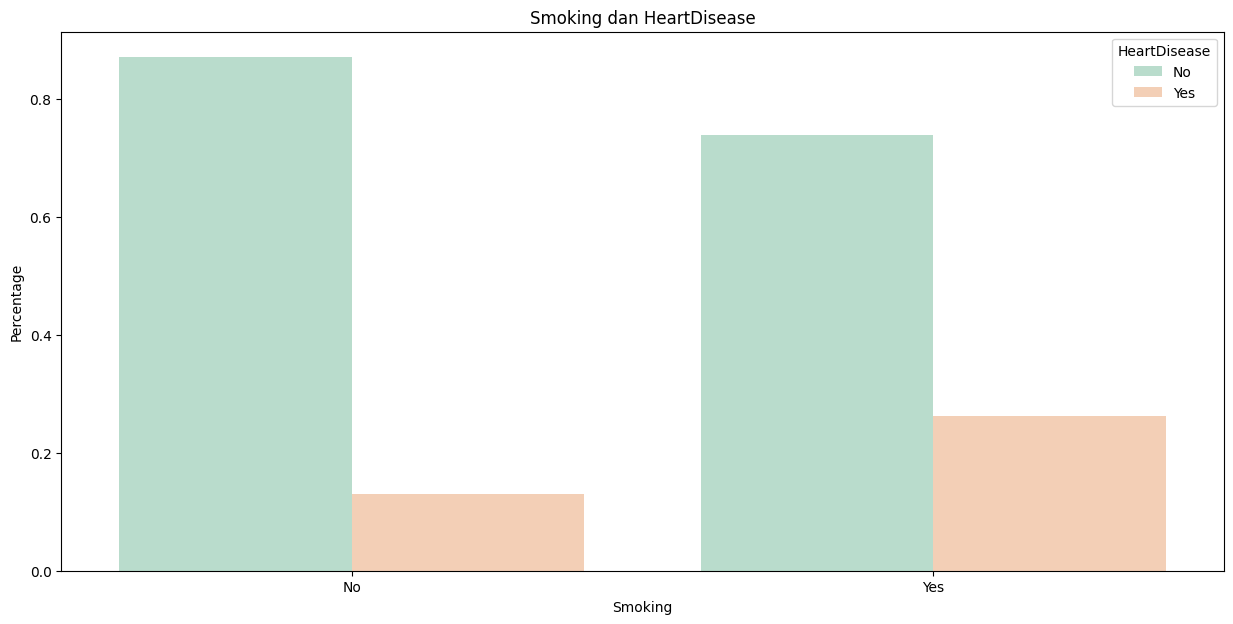

In [20]:
show_relation(obj_cols[0], 'HeartDisease', type_='count')

> Tampak bahwa orang yang memiliki kebiasaan merokok lebih rentan terkena penyakit jantung.

### AlcoholDrinking dan HeartDisease

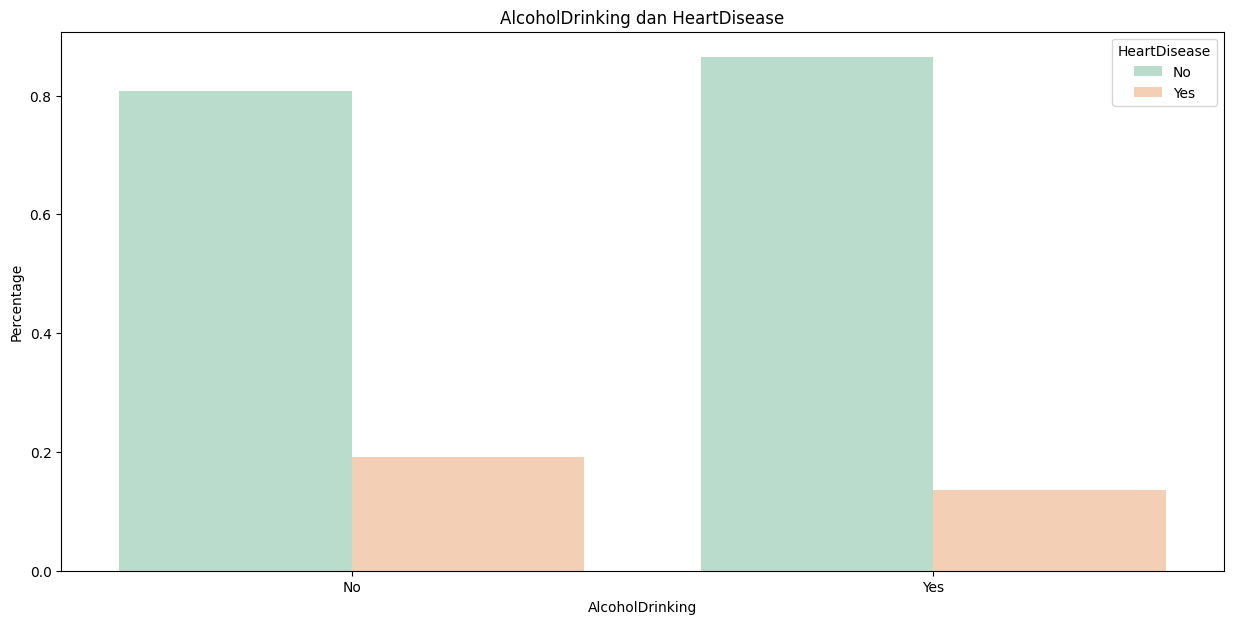

In [21]:
show_relation(obj_cols[1], 'HeartDisease', type_='count')

> Berbeda dengan kebiasaan merokok, orang yang tidak minum alkohol lebih banyak menderita penyakit jantung

### Stroke dan HeartDisease

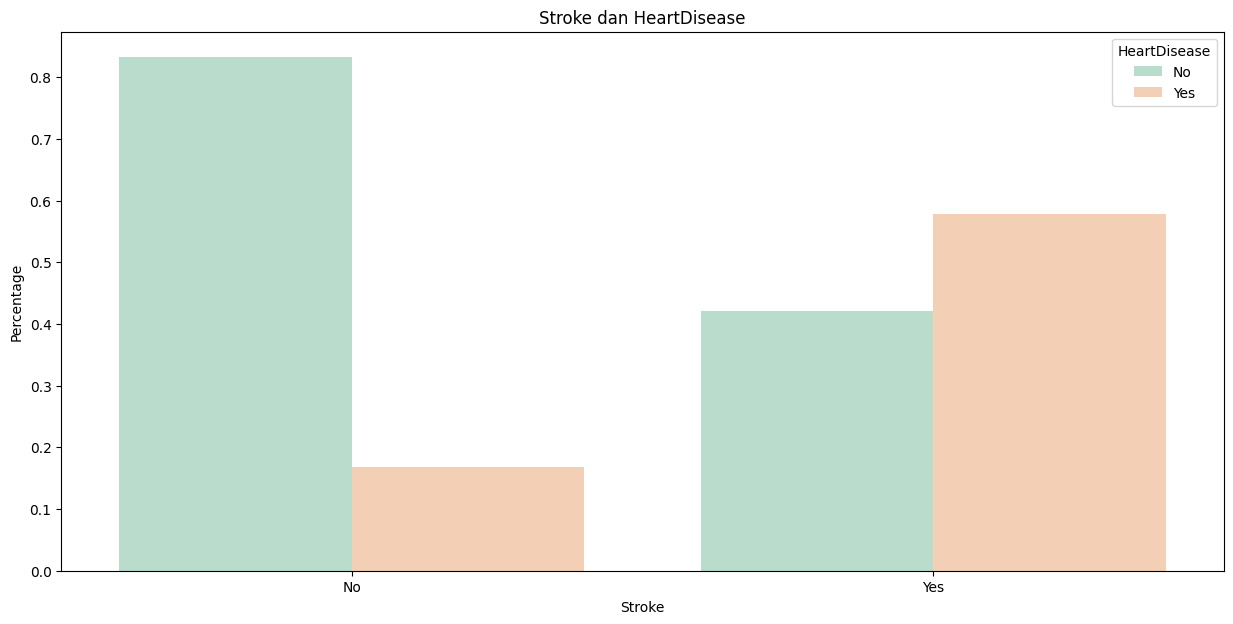

In [22]:
show_relation(obj_cols[2], 'HeartDisease', type_='count')

### Diabetic dan HeartDisease

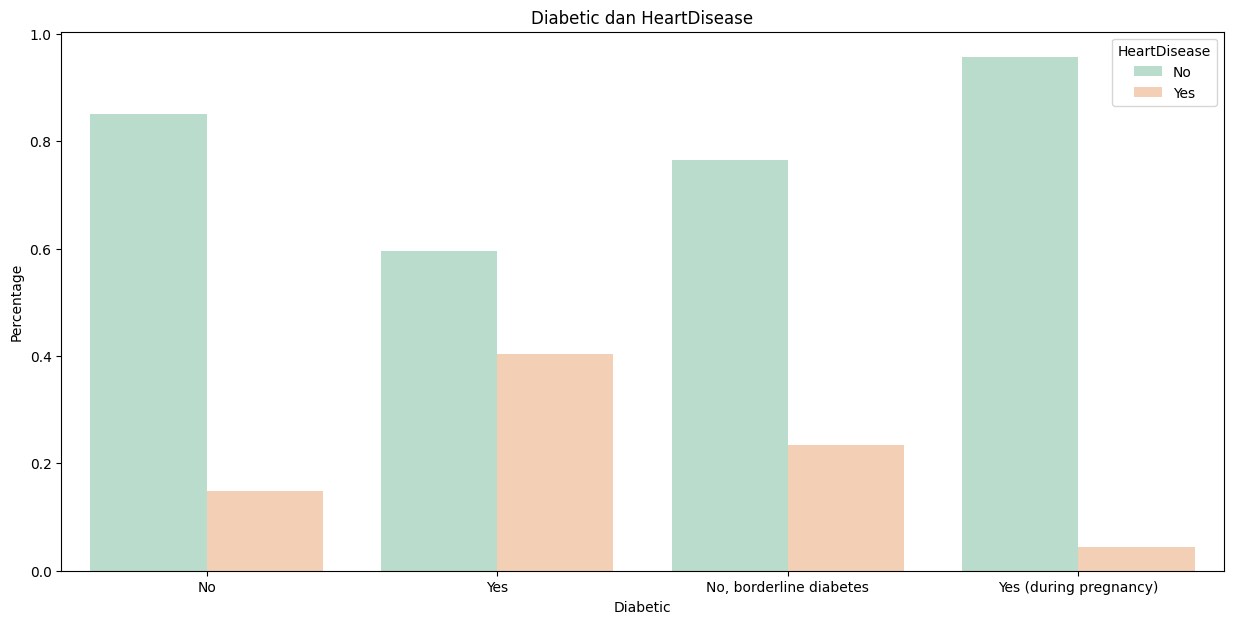

In [23]:
show_relation(obj_cols[7], 'HeartDisease', type_='count')

### Asthma dan HeartDisease

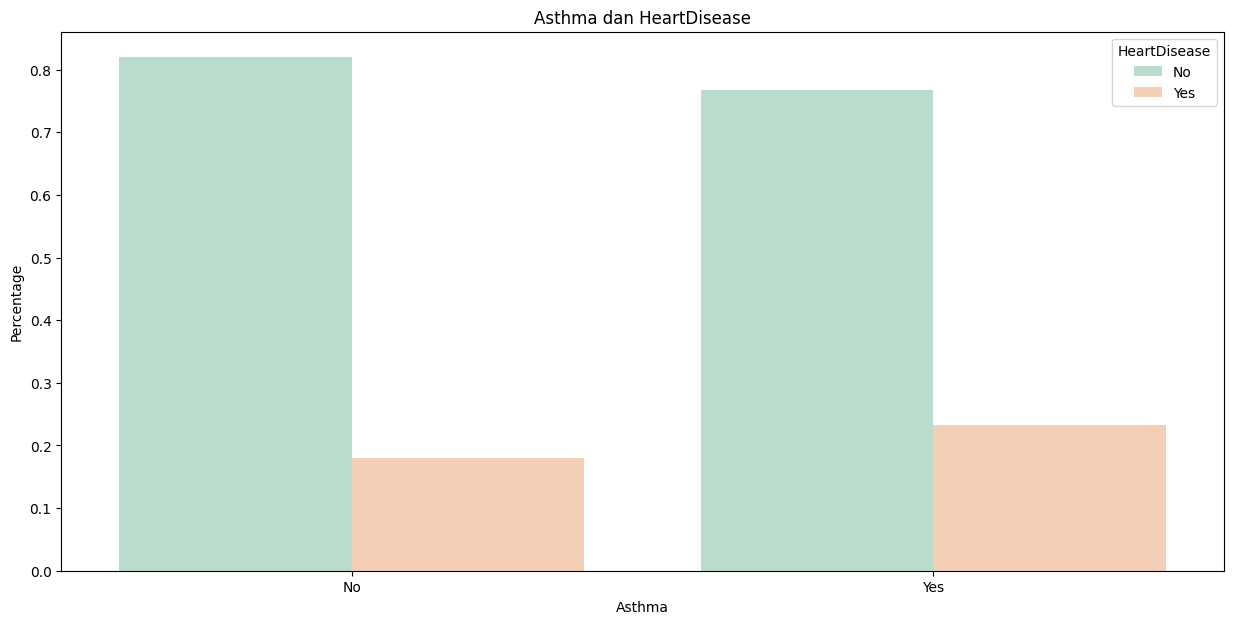

In [24]:
show_relation(obj_cols[10], 'HeartDisease', type_='count')

### Kidney dan HeartDisease

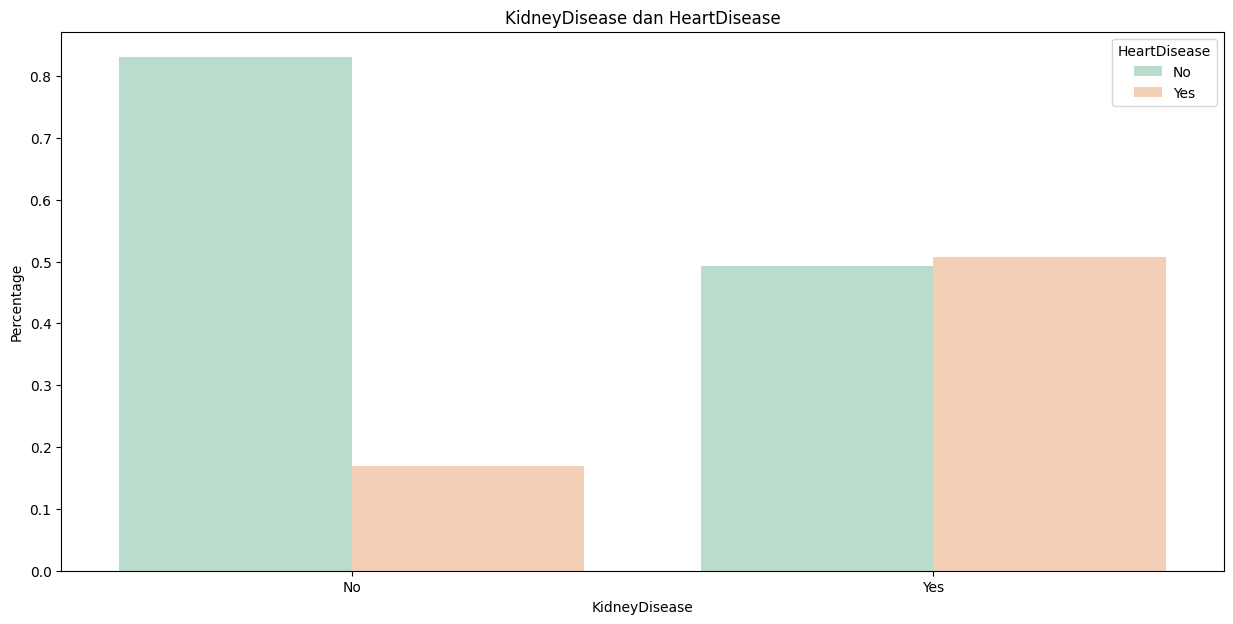

In [25]:
show_relation(obj_cols[11], 'HeartDisease', type_='count')

### SkinCancer dan HeartDisease

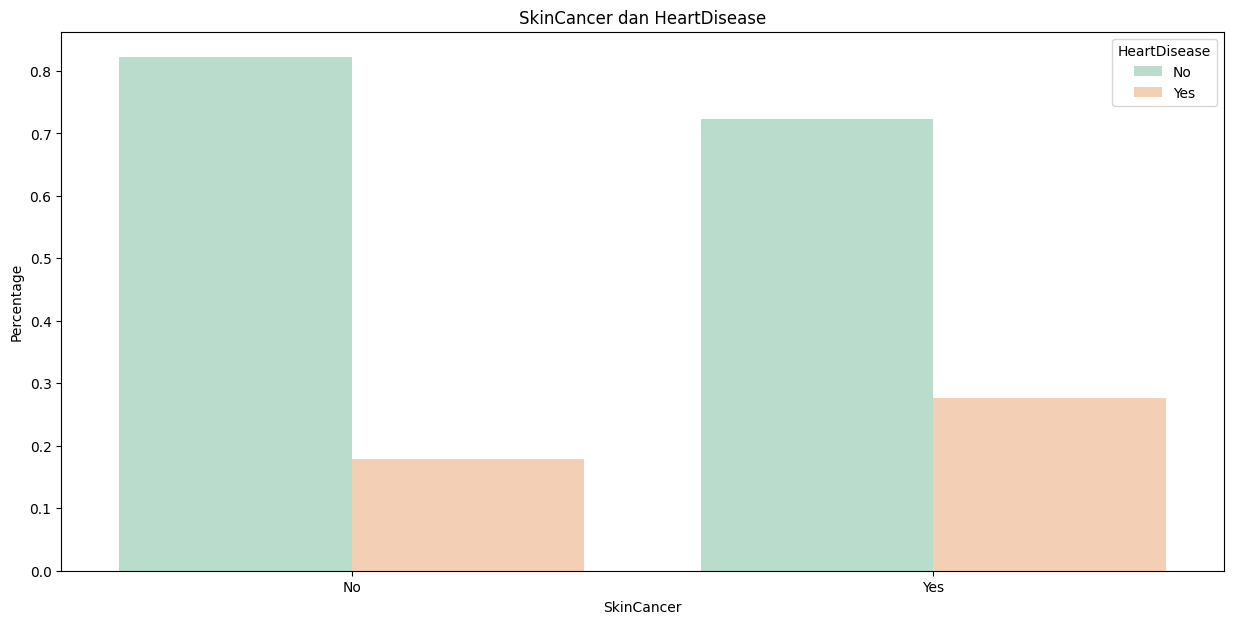

In [26]:
show_relation(obj_cols[12], 'HeartDisease', type_='count')

> Penyakit stroke, diabetes, asma, ginjal, dan kanker kulit berkorelasi tinggi dengan penyakit jantung.

### DiffWalking dan HeartDisease

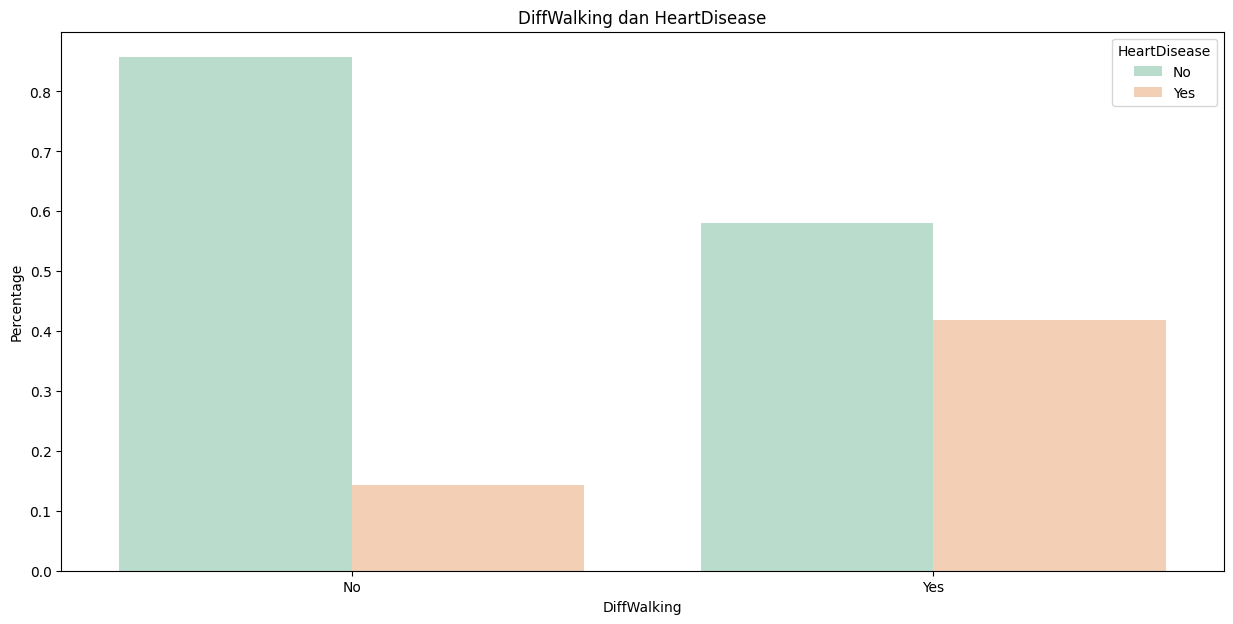

In [27]:
show_relation(obj_cols[3], 'HeartDisease', type_='count')

> Orang yang mengalami kesulitan berjalan lebih banyak menderita penyakit jantung.

# <a id=preprocessing> 3 Preprocessing

- Missing Values

In [28]:
df.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

> Dari informasi tersebut tampak bahwa semua kolom memiliki 100% data. Tidak ada nilai null atau data yang hilang (_missing values_). Jika ada _missing values_, maka kita harus menerapkan beberapa manipulasi data pada kumpulan data tersebut seperti menghapus atribut, menghapus _missing values_, mengisi _missing values_ dengan nilai statistik dasar (mean, median, modus), dan sebagainya.

- Unusual Values

In [29]:
print(f"Unique Values for categorical columns:")
for col in df.select_dtypes(include='object'):
  print(f"  - {col}: {df[col].unique()}")

Unique Values for categorical columns:
  - HeartDisease: ['No' 'Yes']
  - Smoking: ['No' 'Yes']
  - AlcoholDrinking: ['No' 'Yes']
  - Stroke: ['No' 'Yes']
  - DiffWalking: ['No' 'Yes']
  - Sex: ['Male' 'Female']
  - AgeCategory: ['25-29' '65-69' '75-79' '50-54' '55-59' '40-44' '35-39' '60-64' '45-49'
 '80 or older' '70-74' '30-34' '18-24']
  - Race: ['Other' 'White' 'Hispanic' 'Black' 'Asian'
 'American Indian/Alaskan Native']
  - Diabetic: ['No' 'Yes' 'Yes (during pregnancy)' 'No, borderline diabetes']
  - PhysicalActivity: ['Yes' 'No']
  - GenHealth: ['Good' 'Very good' 'Excellent' 'Fair' 'Poor']
  - Asthma: ['No' 'Yes']
  - KidneyDisease: ['No' 'Yes']
  - SkinCancer: ['No' 'Yes']


> Tampak bahwa setiap kolom kategorikal sudah memiliki nilai yang valid dan tidak ada _missing values_.

- Outlier

Fitur Numerikal

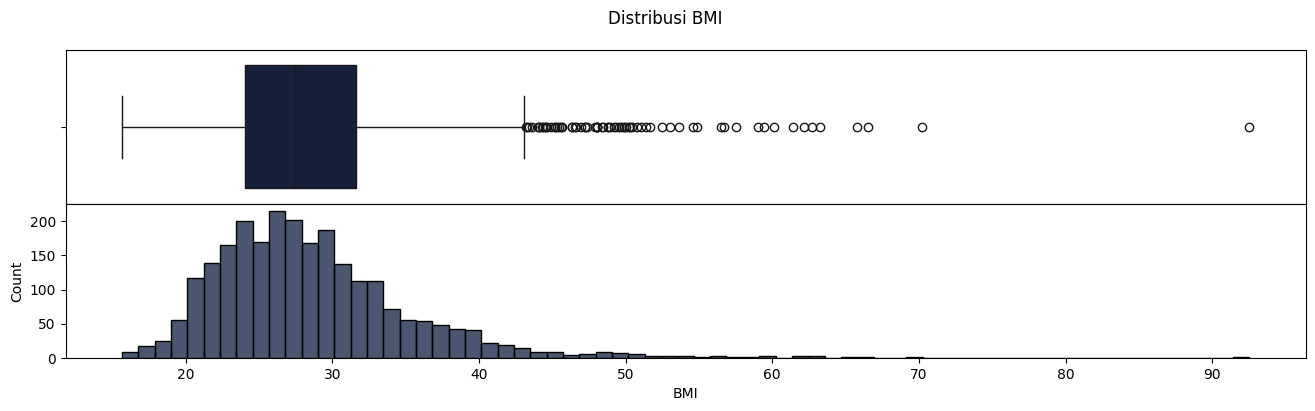

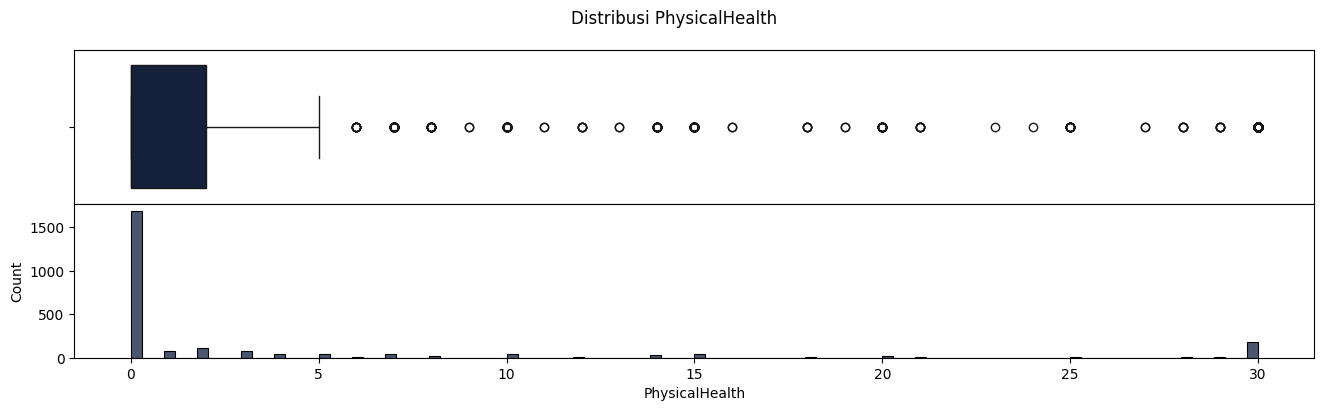

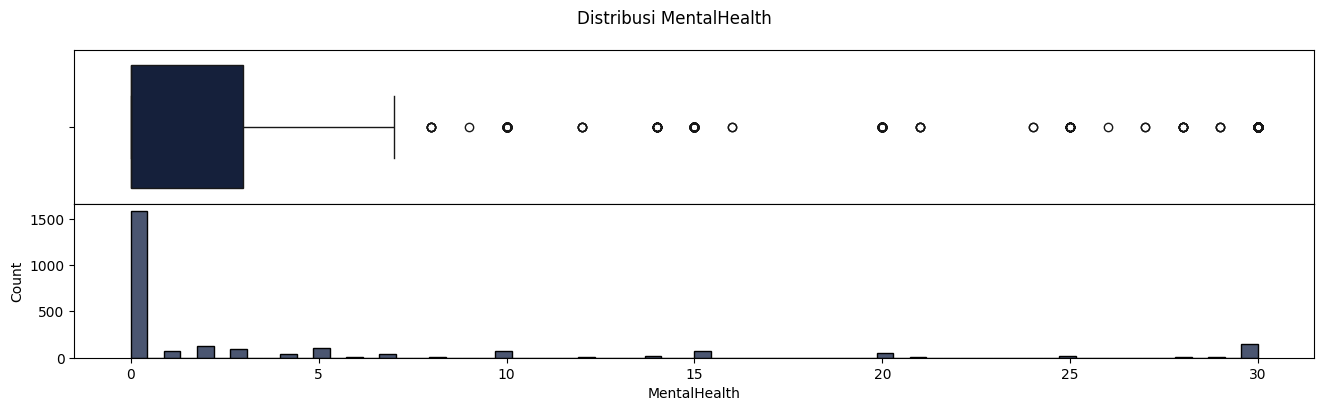

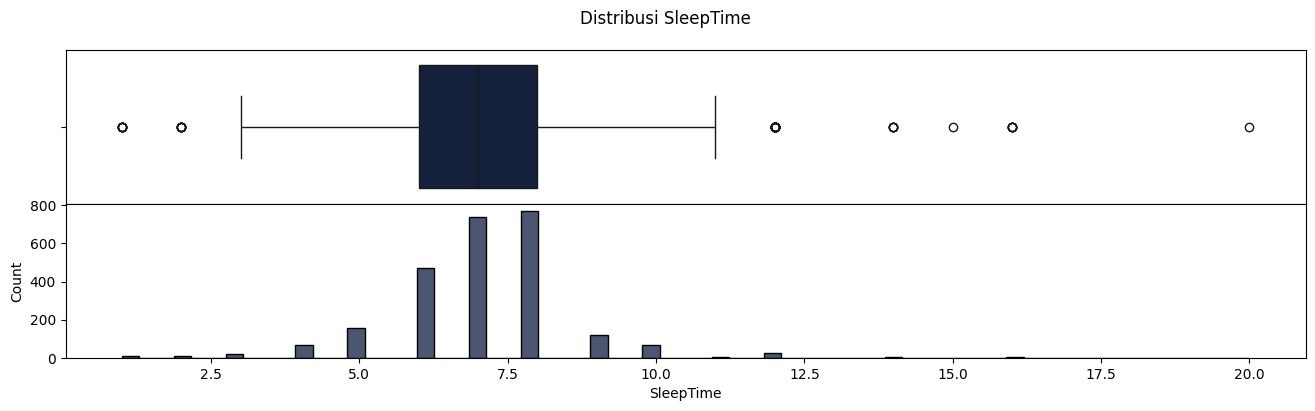

In [30]:
for col in num_cols:
  fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16, 4))
  plt.suptitle(f"Distribusi {col}")
  sns.boxplot(data=df, x=col, ax=ax1, color='#0f1e41')
  ax1.set_xlabel(None)
  ax1.get_xaxis().set_ticks([])
  sns.histplot(data=df, x=col, ax=ax2, color='#0f1e41')
  plt.subplots_adjust(hspace=0)
  plt.show()

> Dari boxplot tersebut tampak bahwa semua fitur numerikal memiliki bias (skewed) dan mengandung outlier dengan rasionya sebagai berikut.

In [31]:
for col in num_cols:
  Q1, Q3 = df[col].quantile([0.25,0.75])
  IQR = Q3 - Q1
  right = Q3 + 1.5 * IQR
  left = Q1 - 1.5 * IQR
  n = len(df.loc[(df[col] < left) | (df[col] > right)])
  print(f"{col}:\n- Outlier Num = {n}\n- Outlier Percentage = {n*100/len(df):.2f}%\n")

BMI:
- Outlier Num = 70
- Outlier Percentage = 2.84%

PhysicalHealth:
- Outlier Num = 434
- Outlier Percentage = 17.62%

MentalHealth:
- Outlier Num = 404
- Outlier Percentage = 16.40%

SleepTime:
- Outlier Num = 51
- Outlier Percentage = 2.07%



Fitur Kategorikal

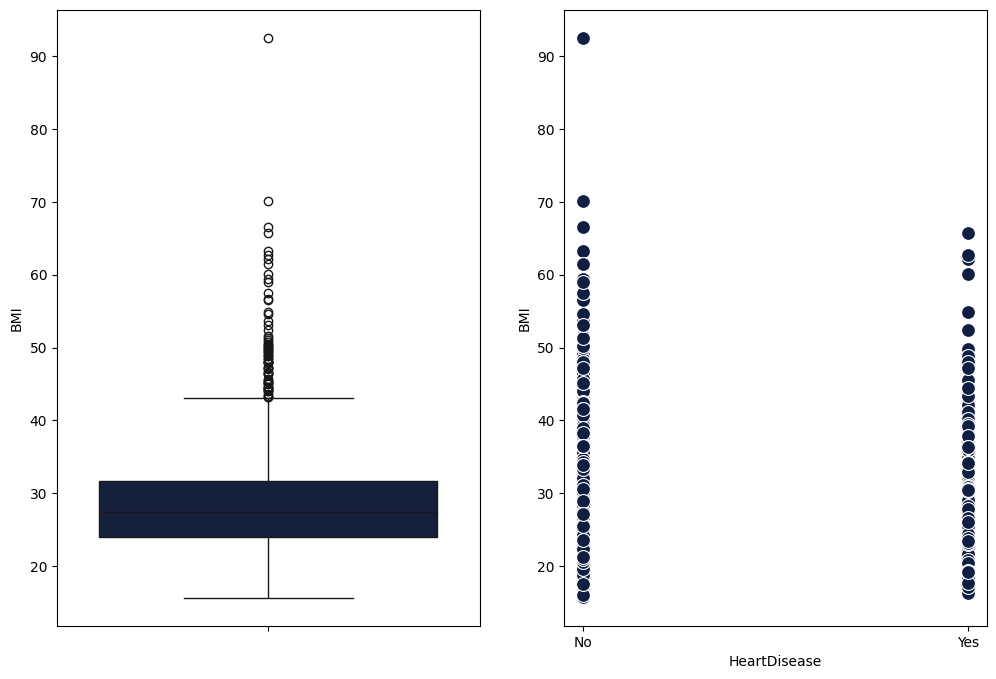

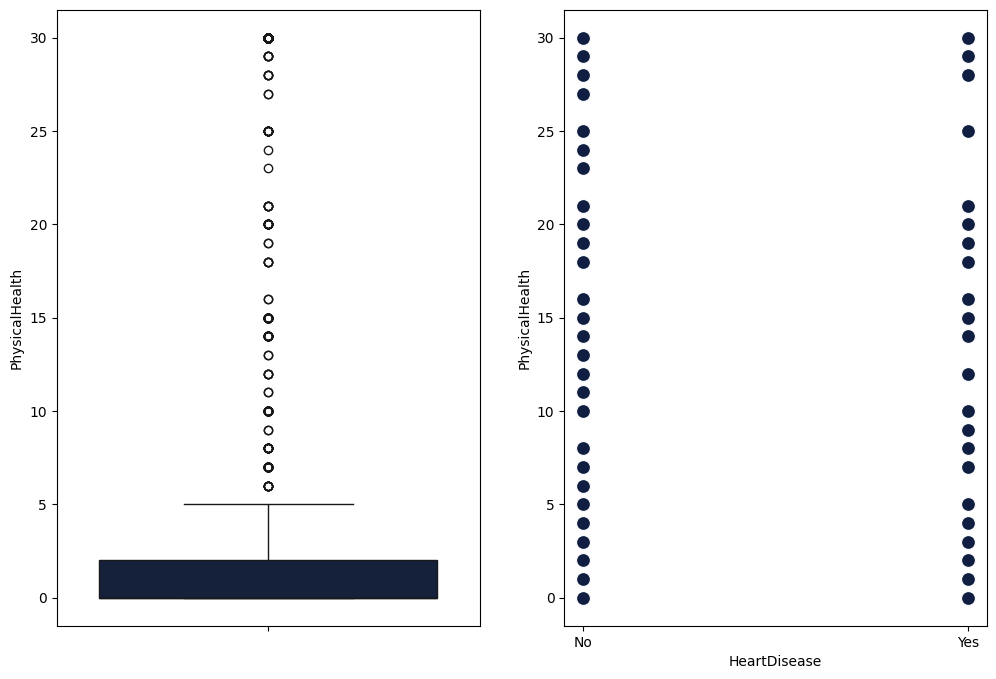

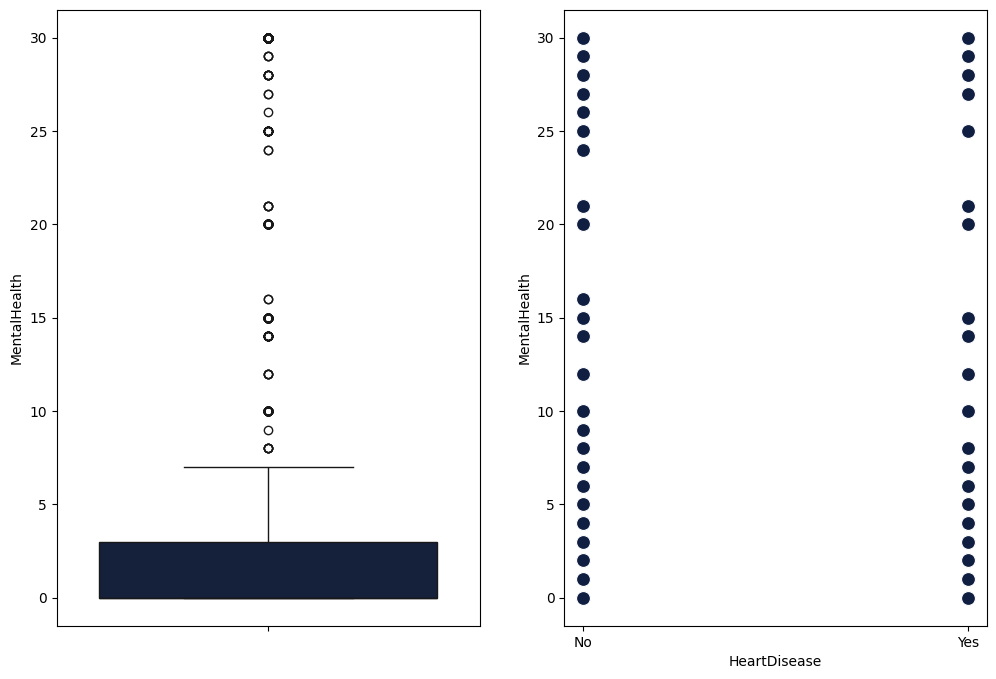

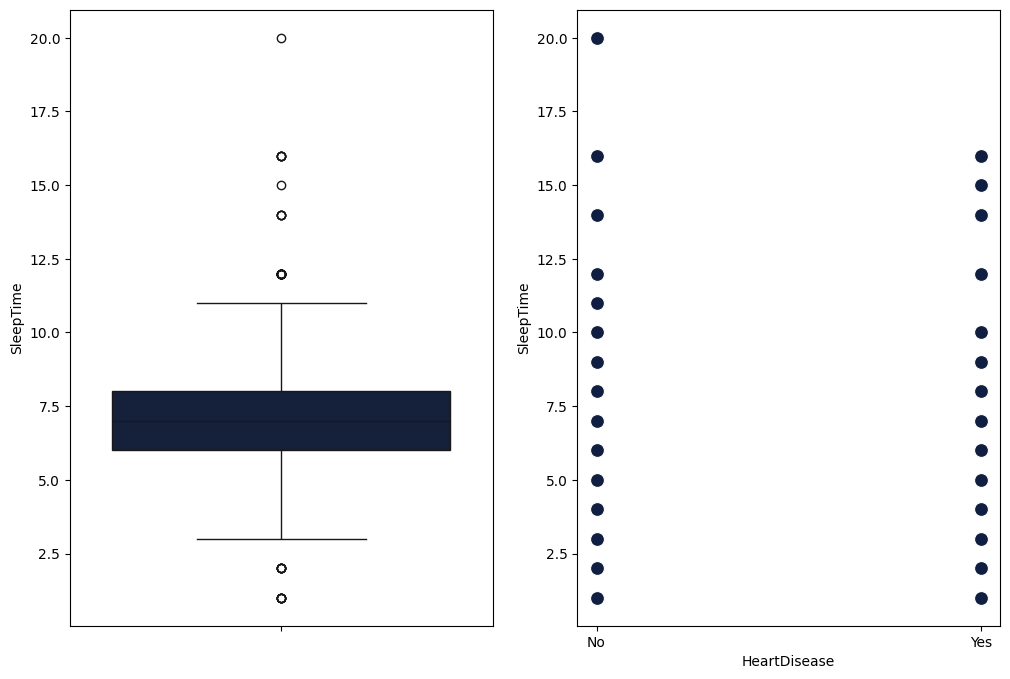

In [32]:
num_cols = df.select_dtypes(exclude='object').columns
for col in num_cols:
    fig, ax =plt.subplots(1,2, figsize=(12,8))
    sns.boxplot(data=df, y=col, ax=ax[0], color='#0f1e41')
    sns.scatterplot(data=df,x = 'HeartDisease', s = 100, y=col, ax=ax[1], color='#0f1e41')
    plt.show()

> Untuk fitur kategorikal tidak ada nilai yang tidak biasa (_unusual values_) sehingga dianggap tidak ada outlier yang perlu ditangani.

- Outlier Removal

In [33]:
zs = df.copy()
for col in num_cols:
  zs[col] = zscore(zs[col])
outscores = np.abs(zs[num_cols])
no_outliers = (outscores<=3.3).all(axis=1)
df2 = df[no_outliers]

> Outlier dapat menyebabkan model menjadi terlalu sensitif terhadap nilai ekstrim. Oleh karena itu, dilakukan penghapusan outlier sehingga dapat membantu model menjadi lebih stabil dan kurang dipengaruhi oleh data ekstrem yang mungkin tidak relevan. Penghapusan outlier juga akan membantu model untuk lebih fokus pada pola umum dalam data, meningkatkan performa dan akurasi.

In [34]:
df2.shape

(2415, 18)

> Setelah outlier dihapus, data yang tersisa adalah 294402 baris dan 18 kolom. Penghapusan outlier ini dilakukan untuk meningkatkan kualitas data, mengurangi distorsi yang disebabkan oleh nilai ekstrem, dan memastikan bahwa analisis yang dilakukan lebih akurat dan representatif dari kondisi sebenarnya.

- Categorical Encoding & Feature Scaling

In [35]:
trans = make_column_transformer(
    (OrdinalEncoder(), obj_cols),
    (StandardScaler(), num_cols),
    remainder='passthrough'
)

trans

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 Index(['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex',
       'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth',
       'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')),
                                ('standardscaler', StandardScaler(),
                                 Index(['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime'], dtype='object'))])

> Categorical Encoding dilakukan untuk mengubah variabel kategorikal menjadi format numerik agar dapat digunakan dalam model machine learning. Sementara Feature Scaling dilakukan untuk mengubah skala fitur numerik untuk memastikan konsistensi dan performa optimal dalam algoritma machine learning.

> Transformasi dilakukan menggunakan Ordinal Encoding dan Standar Scaling. Ordinal Encoding merupakan teknik untuk mengubah fitur kategorikal yang memiliki urutan (ordinal) menjadi format numerik. Sementara Standar Scaling memastikan bahwa fitur numerik memiliki skala yang sama, sehingga tidak ada fitur yang mendominasi yang lain hanya karena skala yang berbeda.

# <a id=modelvalidation> 4 Model and Validation

### Hold Out Validation

- Train Test Split

In [36]:
X = df2.drop(columns=['HeartDisease'])
y =  df2['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

> Membagi dataset menjadi dua bagian: data pelatihan (_training data_) dan data pengujian (_testing data_). 25% data akan digunakan untuk pengujian, sedangkan 75% sisanya untuk pelatihan. Pembagian ini penting untuk melatih model machine learning pada data pelatihan dan menguji performanya pada data pengujian yang tidak terlihat sebelumnya.

- Fit - Transform Data Training dan Testing

In [37]:
X_train_transformed = trans.fit_transform(X_train)
X_test_transformed = trans.transform(X_test)

y_train = np.where(y_train == 'Yes', 1, 0)
y_test = np.where(y_test == 'Yes', 1, 0)

print(X_train_transformed.shape, X_test_transformed.shape)

(1811, 17) (604, 17)


## <a id=supervised> Supervised Learning

In [38]:
import sys
sys.path.append('../src/supervised-learning/')
from sklearn.metrics import accuracy_score, classification_report

### Evaluasi

> Dalam masalah klasifikasi biner ini digunakan metrik Accuracy, Precision, Recall, dan F1-Score untuk mengevaluasi kinerja model supervised learning dengan didasarkan pada pertimbangan sebagai berikut.

>- Accuracy: Metrik ini memberikan gambaran umum tentang seberapa baik model mengklasifikasikan data dengan benar. Namun, karena accuracy hanya menghitung proporsi prediksi yang benar, metrik ini dapat menyesatkan jika data tidak seimbang. Oleh karena itu, accuracy digunakan sebagai metrik awal untuk mengukur performa dasar model.

>- Precision dan Recall: Precision dan recall memberikan pemahaman lebih mendalam tentang performa model, terutama dalam menangani kelas minoritas. Precision dipilih karena dalam beberapa kasus, kesalahan prediksi positif (false positives) mungkin memiliki konsekuensi signifikan, misalnya pada situasi di mana prediksi positif yang salah lebih berisiko. Recall penting untuk meminimalkan kesalahan deteksi negatif (false negatives), terutama jika kegagalan mendeteksi kasus positif lebih kritis.

>- F1-Score: Metrik ini merupakan rata-rata harmonik dari precision dan recall, dan digunakan untuk memberikan keseimbangan ketika ada trade-off antara keduanya. F1-Score sangat berguna dalam situasi di mana data tidak seimbang dan kita membutuhkan satu nilai metrik untuk membandingkan berbagai model.

> Dengan menggunakan precision, recall, dan F1-score selain accuracy, kita dapat memahami bagaimana model menangani kedua kelas dengan lebih baik dan memastikan bahwa model tidak hanya memberikan hasil yang baik secara umum, tetapi juga spesifik terhadap kebutuhan aplikasi.

### KNN

- From Scratch

In [39]:
from knn import KNNScratch

knn_scratch = KNNScratch(k=5, metric='minkowski')
knn_scratch.fit(X_train_transformed, y_train)
y_pred = knn_scratch.predict(X_test_transformed)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8327814569536424
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       504
           1       0.49      0.23      0.31       100

    accuracy                           0.83       604
   macro avg       0.68      0.59      0.61       604
weighted avg       0.80      0.83      0.81       604



- From scikit-learn

In [40]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski')
knn.fit(X_train_transformed, y_train)
y_pred = knn_scratch.predict(X_test_transformed)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8327814569536424
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       504
           1       0.49      0.23      0.31       100

    accuracy                           0.83       604
   macro avg       0.68      0.59      0.61       604
weighted avg       0.80      0.83      0.81       604



- K-Fold Cross-Validation

In [41]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_transformed = trans.fit_transform(X_train)
    X_test_transformed = trans.transform(X_test)

    y_train = np.where(y_train == 'Yes', 1, 0)
    y_test = np.where(y_test == 'Yes', 1, 0)
    
    knn_scratch.fit(X_train_transformed, y_train)
    
    # Prediksi dan evaluasi
    y_pred = knn_scratch.predict(X_test_transformed)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

print(f'Average Accuracy: {sum(accuracies) / len(accuracies)}')


Average Accuracy: 0.8024844720496894


> K-Fold Cross-Validation memberikan penilaian yang lebih stabil dan representatif karena melibatkan beberapa pembagian data, tetapi lebih memakan waktu karena melibatkan banyak pelatihan dan evaluasi.

### Logistic Regression

- From Scratch

In [42]:
from logistic_regression import LogisticRegressionScratch

logreg_scratch = LogisticRegressionScratch(
    learning_rate=0.01, 
    n_iterations=1000, 
    regularization='l2', 
    C=1.0
)
logreg_scratch.fit(X_train_transformed, y_train)
y_pred = logreg_scratch.predict(X_test_transformed)
print()
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Iteration 0, Cost: 0.6438170316239934
Iteration 100, Cost: 0.4743809773958058
Iteration 200, Cost: 0.45266933329669806
Iteration 300, Cost: 0.4439017489800091
Iteration 400, Cost: 0.4393006243777844
Iteration 500, Cost: 0.43640667635064156
Iteration 600, Cost: 0.4343286763537322
Iteration 700, Cost: 0.4326861121778294
Iteration 800, Cost: 0.43129746299236515
Iteration 900, Cost: 0.4300689930542349

Accuracy: 0.8219461697722568
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       399
           1       0.45      0.11      0.17        84

    accuracy                           0.82       483
   macro avg       0.64      0.54      0.54       483
weighted avg       0.77      0.82      0.77       483



- From scikit-learn

In [43]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    penalty='l2',       
    C=1.0,              
    max_iter=1000,      
    random_state=42     
)
logreg.fit(X_train_transformed, y_train)

y_pred = logreg.predict(X_test_transformed)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8322981366459627
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       399
           1       0.56      0.18      0.27        84

    accuracy                           0.83       483
   macro avg       0.70      0.57      0.59       483
weighted avg       0.80      0.83      0.79       483



### Gaussian Naive Bayes

- From Scratch

In [44]:
from gaussian_naive_bayes import GaussianNaiveBayesScratch

gaussian_scratch = GaussianNaiveBayesScratch()
gaussian_scratch.fit(X_train_transformed, y_train)
preds = gaussian_scratch.predict(X_test_transformed)

print(f'Accuracy: {accuracy_score(y_test, preds)}')
print(classification_report(y_test, preds))

Accuracy: 0.8012422360248447
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       399
           1       0.43      0.43      0.43        84

    accuracy                           0.80       483
   macro avg       0.65      0.65      0.65       483
weighted avg       0.80      0.80      0.80       483



- From scikit-learn

In [45]:
from sklearn.naive_bayes import GaussianNB

gaussianNB = GaussianNB()
gaussianNB.fit(X_train_transformed, y_train)
y_pred = gaussianNB.predict(X_test_transformed)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8012422360248447
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       399
           1       0.43      0.43      0.43        84

    accuracy                           0.80       483
   macro avg       0.65      0.65      0.65       483
weighted avg       0.80      0.80      0.80       483



### CART

- From Scratch

In [46]:
from cart import DecisionTreeScratch

decisiontree_scratch = DecisionTreeScratch(max_depth=4)
decisiontree_scratch.fit(X_train_transformed, y_train)
y_pred = decisiontree_scratch.predict(X_test_transformed)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8136645962732919
              precision    recall  f1-score   support

           0       0.83      0.97      0.90       399
           1       0.31      0.06      0.10        84

    accuracy                           0.81       483
   macro avg       0.57      0.52      0.50       483
weighted avg       0.74      0.81      0.76       483



- From scikit-learn

In [47]:
from sklearn.tree import DecisionTreeClassifier

decisiontree = DecisionTreeClassifier(max_depth=4)
decisiontree.fit(X_train_transformed, y_train)
y_pred = decisiontree.predict(X_test_transformed)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.8240165631469979
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       399
           1       0.49      0.21      0.30        84

    accuracy                           0.82       483
   macro avg       0.67      0.58      0.60       483
weighted avg       0.79      0.82      0.79       483



### SVM

- From Scratch

In [48]:
from svm import LinearSVC

svc_scratch = LinearSVC(optimizer='quadratic', kernel='linear', C=1.0)
svc_scratch.fit(X_train_transformed, y_train)
preds = svc_scratch.predict(X_test_transformed)

print(f'Accuracy: {accuracy_score(y_test, preds)}')
print(classification_report(y_test, preds, zero_division=0))

     pcost       dcost       gap    pres   dres
 0: -1.5680e+03 -3.5000e+03  8e+03  1e+00  1e-16
 1: -1.3032e+03 -2.2257e+03  1e+03  1e-02  3e-16
 2: -1.5397e+03 -1.5777e+03  4e+01  6e-04  3e-16
 3: -1.5677e+03 -1.5681e+03  4e-01  6e-06  2e-16
 4: -1.5680e+03 -1.5680e+03  4e-03  6e-08  4e-16
 5: -1.5680e+03 -1.5680e+03  4e-05  6e-10  4e-16
Optimal solution found.
Accuracy: 0.8260869565217391
              precision    recall  f1-score   support

           0       0.83      1.00      0.90       399
           1       0.00      0.00      0.00        84

    accuracy                           0.83       483
   macro avg       0.41      0.50      0.45       483
weighted avg       0.68      0.83      0.75       483



In [49]:
from sklearn.svm import SVC

svc = SVC(C=1.0, kernel='linear')
svc.fit(X_train_transformed, y_train)
y_pred = svc.predict(X_test_transformed)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))


Accuracy: 0.8302277432712215
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       399
           1       0.55      0.14      0.23        84

    accuracy                           0.83       483
   macro avg       0.69      0.56      0.57       483
weighted avg       0.79      0.83      0.79       483



## <a id=unsupervised> Unsupervised Learning

In [50]:
import sys
sys.path.append('../src/unsupervised-learning/')
from sklearn.metrics import silhouette_score, davies_bouldin_score

### Evaluasi

> Dalam masalah klasifikasi biner ini digunakan metrik Silhouette Score dan Davies-Bouldin Score untuk mengevaluasi kinerja model unsupervised learning dengan didasarkan pada pertimbangan sebagai berikut.

>- Silhouette Score: Metrik ini mengukur seberapa baik setiap titik data dikelompokkan dengan cluster-nya sendiri dibandingkan dengan cluster lain. Nilai silhouette score berkisar dari -1 hingga 1, di mana nilai yang lebih tinggi menunjukkan clustering yang lebih baik (lebih dekat dengan cluster-nya dan lebih jauh dari cluster lain). Silhouette score sangat cocok dalam konteks ini karena memberikan gambaran yang jelas tentang seberapa terpisah dan konsisten cluster yang terbentuk.

>- Davies-Bouldin Score: Metrik ini mengukur rata-rata kesamaan (rasio jarak dalam-cluster dan antar-cluster) untuk setiap cluster, dengan nilai yang lebih rendah menunjukkan clustering yang lebih baik. Metrik ini sesuai karena membantu mengevaluasi seberapa terpisah cluster yang dihasilkan, yang merupakan indikator kunci dari keberhasilan clustering dalam kasus biner unsupervised.

In [51]:
X_preprocessed = trans.fit_transform(X)

### K-Means

- From Scratch

In [52]:
from k_means import KMeansScratch

kmeans_scratch = KMeansScratch(n_clusters=3, max_iter=500, init_method='kmeans')
kmeans_scratch.fit(X_preprocessed)
labels = kmeans_scratch.get_labels()
centroids = kmeans_scratch.get_centroids()
predictions = kmeans_scratch.predict(X_preprocessed)

print('Centroids:\n', centroids)

silhouette_avg = silhouette_score(X_preprocessed, kmeans_scratch.get_labels())
print('\nSilhouette Score:', silhouette_avg)

davies_bouldin = davies_bouldin_score(X_preprocessed, kmeans_scratch.get_labels())
print('Davies-Bouldin Index:', davies_bouldin)

Centroids:
 [[ 4.45121951e-01  8.41463415e-02  5.00000000e-02  1.58536585e-01
   5.04878049e-01  6.64756098e+00  4.43414634e+00  3.48780488e-01
   7.96341463e-01  2.11707317e+00  1.78048780e-01  3.90243902e-02
   7.31707317e-02  1.52477468e-01  8.71993049e-02  4.09587821e-02
  -1.30459479e-01]
 [ 3.45794393e-01  7.47663551e-02  4.67289720e-03  4.20560748e-02
   5.26479751e-01  2.05140187e+00  4.17601246e+00  1.13707165e-01
   8.33333333e-01  2.17912773e+00  1.63551402e-01  1.40186916e-02
   3.11526480e-03 -9.63909881e-02 -1.91326345e-01  2.21559722e-01
  -1.18276643e-01]
 [ 4.96327387e-01  4.51206716e-02  7.45015740e-02  2.33997901e-01
   4.43861490e-01  1.03504722e+01  4.66946485e+00  4.81636936e-01
   6.97796432e-01  2.28961175e+00  1.08079748e-01  8.81427072e-02
   1.85729276e-01 -6.62628641e-02  5.38594792e-02 -1.84498996e-01
   1.91931141e-01]]

Silhouette Score: 0.22276989899107055
Davies-Bouldin Index: 1.5664437376513092


- From scikit-learn

In [53]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=500)
kmeans.fit(X_preprocessed)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_
print('Centroids:\n', centroids)

silhouette_avg = silhouette_score(X_preprocessed, labels)
davies_bouldin = davies_bouldin_score(X_preprocessed, labels)
print('\nSilhouette Score:', silhouette_avg)
print('Davies-Bouldin Index:', davies_bouldin)

Centroids:
 [[ 4.96327387e-01  4.51206716e-02  7.45015740e-02  2.33997901e-01
   4.43861490e-01  1.03504722e+01  4.66946485e+00  4.81636936e-01
   6.97796432e-01  2.28961175e+00  1.08079748e-01  8.81427072e-02
   1.85729276e-01 -6.62628641e-02  5.38594792e-02 -1.84498996e-01
   1.91931141e-01]
 [ 4.45121951e-01  8.41463415e-02  5.00000000e-02  1.58536585e-01
   5.04878049e-01  6.64756098e+00  4.43414634e+00  3.48780488e-01
   7.96341463e-01  2.11707317e+00  1.78048780e-01  3.90243902e-02
   7.31707317e-02  1.52477468e-01  8.71993049e-02  4.09587821e-02
  -1.30459479e-01]
 [ 3.45794393e-01  7.47663551e-02  4.67289720e-03  4.20560748e-02
   5.26479751e-01  2.05140187e+00  4.17601246e+00  1.13707165e-01
   8.33333333e-01  2.17912773e+00  1.63551402e-01  1.40186916e-02
   3.11526480e-03 -9.63909881e-02 -1.91326345e-01  2.21559722e-01
  -1.18276643e-01]]

Silhouette Score: 0.22276989899107055
Davies-Bouldin Index: 1.5664437376513092


### DBSCAN

- From Scratch

In [54]:
from dbscan import DBSCAN

dbscan_custom = DBSCAN(epsilon=1.5, min_samples=2, metric='euclidean')
labels_custom = dbscan_custom.fit(X_preprocessed)

silhouette_scratch = silhouette_score(X_preprocessed, labels_custom)
dbi_scratch = davies_bouldin_score(X_preprocessed, labels_custom)
print('Silhouette Score (DBSCAN from scratch):', silhouette_scratch)
print('Davies-Bouldin Index (DBSCAN from scratch):', dbi_scratch)

Silhouette Score (DBSCAN from scratch): -0.41258868246287606
Davies-Bouldin Index (DBSCAN from scratch): 1.484042732733766


- From scikit-learn

In [55]:
from sklearn.cluster import DBSCAN as SklearnDBSCAN

dbscan_sklearn = SklearnDBSCAN(eps=1.5, min_samples=2, metric='euclidean')
labels_sklearn = dbscan_sklearn.fit_predict(X_preprocessed)

silhouette_scikit = silhouette_score(X_preprocessed, labels_sklearn)
dbi_scikit = davies_bouldin_score(X_preprocessed, labels_sklearn)
print('Silhouette Score (DBSCAN from scratch):', silhouette_scikit)
print('Davies-Bouldin Index (DBSCAN from scratch):', dbi_scikit)

Silhouette Score (DBSCAN from scratch): -0.41258868246287606
Davies-Bouldin Index (DBSCAN from scratch): 1.484042732733766


### PCA

- From Scratch

In [56]:
from pca import PCAScratch

pca = PCAScratch(n_components=2)
X_pca_scratch = pca.fit_transform(X_preprocessed)

print('Data setelah PCA:')
print(X_pca_scratch)

print('\nKomponen utama:')
print(pca.components_)

print('\nPersentase explained variance dari tiap komponen:')
print(pca.explained_variance_)

Data setelah PCA:
[[-5.91600974  0.09629415]
 [ 2.13804043 -1.86573936]
 [ 3.8931435   2.38558965]
 ...
 [ 3.17743598 -0.55307688]
 [ 2.16683244  0.19072479]
 [ 5.26946903 -0.57551978]]

Komponen utama:
[[ 0.02154493 -0.0010277 ]
 [-0.00291384 -0.00205451]
 [ 0.00797286  0.00346774]
 [ 0.02498181  0.02011766]
 [-0.01022103 -0.00339059]
 [ 0.99331706  0.02196462]
 [ 0.06550577 -0.08504673]
 [ 0.04377031  0.02897547]
 [-0.01793922 -0.01093757]
 [ 0.01963611 -0.99230546]
 [-0.0065307   0.00476126]
 [ 0.00901843  0.01008831]
 [ 0.02204657 -0.00142238]
 [ 0.00355568 -0.03925532]
 [ 0.03072379  0.06385944]
 [-0.04791266  0.01984478]
 [ 0.03577614  0.00908157]]

Persentase explained variance dari tiap komponen:
[0.58025585 0.10370574]


- From scikit-learn

In [57]:
from sklearn.decomposition import PCA as SKPCA

sklearn_pca = SKPCA(n_components=2)
X_pca_sklearn = sklearn_pca.fit_transform(X_preprocessed)

print('Data setelah PCA:')
print(X_pca_sklearn)
print('\nKomponen utama (Scikit-learn PCA):')
print(sklearn_pca.components_)
print('\nPersentase explained variance dari tiap komponen (Scikit-learn PCA):')
print(sklearn_pca.explained_variance_ratio_)


Data setelah PCA:
[[-5.91600974 -0.09629415]
 [ 2.13804043  1.86573936]
 [ 3.8931435  -2.38558965]
 ...
 [ 3.17743598  0.55307688]
 [ 2.16683244 -0.19072479]
 [ 5.26946903  0.57551978]]

Komponen utama (Scikit-learn PCA):
[[ 0.02154493 -0.00291384  0.00797286  0.02498181 -0.01022103  0.99331706
   0.06550577  0.04377031 -0.01793922  0.01963611 -0.0065307   0.00901843
   0.02204657  0.00355568  0.03072379 -0.04791266  0.03577614]
 [ 0.0010277   0.00205451 -0.00346774 -0.02011766  0.00339059 -0.02196462
   0.08504673 -0.02897547  0.01093757  0.99230546 -0.00476126 -0.01008831
   0.00142238  0.03925532 -0.06385944 -0.01984478 -0.00908157]]

Persentase explained variance dari tiap komponen (Scikit-learn PCA):
[0.58025585 0.10370574]
